In [24]:
# Step 1: Install FFTW
!apt-get install libfftw3-dev
!apt-get install libfftw3-mpi-dev

# Step 2: Set paths for Dedalus installation
import os
os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

# Step 3: Install Dedalus using pip
!pip3 install dedalus

#2D Rayleigh-Bernard convection in Boussineq approximation

#Importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.public as de
from dedalus.extras import flow_tools
from dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RB Convection')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libfftw3-dev is already the newest version (3.3.7-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libfftw3-mpi-dev is already the newest version (3.3.7-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
# clean up the destination files  
!rm -rf /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots

In [41]:
#Defining variables
Lx, d = (16. ,9.)
xres, zres = (128*3,64*3) #Change these to change resolution

#Non-dimensional numbers
Pr = 1
Ra = 1.0e8

In [42]:
#Defining basis and domains
xbasis = de.Fourier('x',xres,interval=(0,Lx),dealias=3/2)
zbasis = de.Chebyshev('z',zres,interval=(0,d),dealias=3/2)

domain  = de.Domain([xbasis,zbasis],grid_dtype=np.float64)
problem = de.IVP(domain,variables=['T','p','u','w','Tz','uz','wz'])

DEBUG:domain:Global coeff shape: [192 192]
DEBUG:distributor:Mesh: []


In [43]:
#Defining non-dimensional parameters
problem.parameters['Pr'] = Pr
problem.parameters['Ra'] = Ra
problem.parameters['xres'] = xres

#Main Boussineq Rayleigh-Bernard convection equations
problem.add_equation("dt(u) + dx(p) - (dx(dx(u)) + dz(uz)) = - (u * dx(u) + w * uz)")
problem.add_equation("dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T = - (u * dx(w) + w * wz)")
problem.add_equation("dt(T) - (1 / Pr) * (dx(dx(T)) + dz(Tz)) = - (u * dx(T) + w * Tz)")

#Auxillary equations
problem.add_equation("dz(u) - uz = 0")
problem.add_equation("dz(w) - wz = 0")
problem.add_equation("dz(T) - Tz = 0")

#Continuity equation
problem.add_equation("dx(u) + wz = 0")

#Boundary conditions

#Fixed temperature at top boundary
problem.add_bc("right(T) = 0")

#Fixed flux on bottom boundary
problem.add_bc("left(Tz) = -1")

#Standard fluid dynamics boundary conditions
problem.add_bc("left(u)  = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(w)  = 0")
problem.add_bc("right(w) = 0",condition="(nx != 0)")
problem.add_bc("right(p) = 0",condition="(nx == 0)")

DEBUG:problems:Parsing Eqn 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dt(u) + dx(p) - (dx(dx(u)) + dz(uz))
DEBUG:problems:  RHS string form: - (u * dx(u) + w * uz)
DEBUG:problems:  LHS object form: (dt(u) + dx(p)) + (-1*(dx(dx(u)) + dz(uz)))
DEBUG:problems:  RHS object form: -1*((u*dx(u)) + (w*uz))
DEBUG:problems:  M linear form: u
DEBUG:problems:  L linear form: dx(p) + ((-1*dx(dx(u))) + (-1*dz(uz)))
DEBUG:problems:Parsing Eqn 1
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dt(w) + dz(p) - (dx(dx(w)) + dz(wz)) - (Ra / Pr) * T
DEBUG:problems:  RHS string form: - (u * dx(w) + w * wz)
DEBUG:problems:  LHS object form: ((dt(w) + dz(p)) + (-1*(dx(dx(w)) + dz(wz)))) + (-1*((Ra*(Pr**-1))*T))
DEBUG:problems:  RHS object form: -1*((u*dx(w)) + (w*wz))
DEBUG:problems:  M linear form: w
DEBUG:problems:  L linear form: (dz(p) + ((-1*dx(dx(w))) + (-1*dz(wz)))) + ((-1*(Ra*(Pr**-1)))*T)
DEBUG:problems:Parsing Eqn 2
DEBUG:problems:  Condition: True
DEBUG:

In [44]:
#Build solver
solver = problem.build_solver(de.timesteppers.RK111) #RK111 = first order runge kutte timestepping method
logger.info('Solver built')

DEBUG:solvers:Beginning IVP instantiation
INFO:pencil:Building pencil matrix 1/192 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 4.4e+01/s


2022-09-18 23:07:18,073 pencil 0/1 INFO :: Building pencil matrix 1/192 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 4.4e+01/s


INFO:pencil:Building pencil matrix 20/192 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 4.7e+01/s


2022-09-18 23:07:18,473 pencil 0/1 INFO :: Building pencil matrix 20/192 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 4.7e+01/s


INFO:pencil:Building pencil matrix 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 4.7e+01/s


2022-09-18 23:07:18,907 pencil 0/1 INFO :: Building pencil matrix 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 4.7e+01/s


INFO:pencil:Building pencil matrix 60/192 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 4.7e+01/s


2022-09-18 23:07:19,339 pencil 0/1 INFO :: Building pencil matrix 60/192 (~31%) Elapsed: 1s, Remaining: 3s, Rate: 4.7e+01/s


INFO:pencil:Building pencil matrix 80/192 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 4.6e+01/s


2022-09-18 23:07:19,775 pencil 0/1 INFO :: Building pencil matrix 80/192 (~42%) Elapsed: 2s, Remaining: 2s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 4.6e+01/s


2022-09-18 23:07:20,206 pencil 0/1 INFO :: Building pencil matrix 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 120/192 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 4.6e+01/s


2022-09-18 23:07:20,635 pencil 0/1 INFO :: Building pencil matrix 120/192 (~62%) Elapsed: 3s, Remaining: 2s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 140/192 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 4.6e+01/s


2022-09-18 23:07:21,069 pencil 0/1 INFO :: Building pencil matrix 140/192 (~73%) Elapsed: 3s, Remaining: 1s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 160/192 (~83%) Elapsed: 3s, Remaining: 1s, Rate: 4.6e+01/s


2022-09-18 23:07:21,497 pencil 0/1 INFO :: Building pencil matrix 160/192 (~83%) Elapsed: 3s, Remaining: 1s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 180/192 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 4.6e+01/s


2022-09-18 23:07:21,937 pencil 0/1 INFO :: Building pencil matrix 180/192 (~94%) Elapsed: 4s, Remaining: 0s, Rate: 4.6e+01/s


INFO:pencil:Building pencil matrix 192/192 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 4.6e+01/s


2022-09-18 23:07:22,207 pencil 0/1 INFO :: Building pencil matrix 192/192 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 4.6e+01/s


DEBUG:solvers:Finished IVP instantiation
INFO:2D RB Convection:Solver built


2022-09-18 23:07:22,243 2D RB Convection 0/1 INFO :: Solver built


In [45]:
#Initial conditions or restart
if not pathlib.Path('restart.h5').exists():

    #Initial conditions
    x, z = domain.all_grids()
    zz,xx  = np.meshgrid(z,x)
    T = solver.state['T']
    Tz = solver.state['Tz']

    #Creating random perturbations
    gshape = domain.dist.grid_layout.global_shape(scales=1)
    slices = domain.dist.grid_layout.slices(scales=1)
    rand   = np.random.RandomState(seed=42)
    noise  = rand.standard_normal(gshape)[slices]
    location_x = random.sample(range(xres), 80)
    location_z = random.sample(range(zres), 80)
    noise      = np.zeros((xres,zres))
    for i in range(40):
        noise =  0.1*np.exp(-(xx-xx[location_x[i],location_z[i]])**2/0.3**2-(zz-0)**2/0.2**2)+noise
    for i in range(40,80):
        noise = -0.1*np.exp(-(xx-xx[location_x[i],location_z[i]])**2/0.3**2-(zz-9)**2/0.2**2)+noise
      

    #Linear background + perturbations damped at walls
    zb,zt = zbasis.interval
    pert = 1e-1 * noise * (zt - z) * (z - zb)
    T['g'] = pert
    T.differentiate('z',out=Tz)

    #Timestepping and output
    dt = 5e-8
    stop_sim_time = 5 #Change this to change total sim time
    fh_mode = 'overwrite'

else:
    #Restart
    write,last_dt = solver.load_state('restart.h5', -1)

    #Timestepping and output
    dt = last_dt
    stop_sim_time = 5e-3
    fh_mode = 'append'

DEBUG:basis:Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (384, 192), 0)
DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (192, 192), 1)


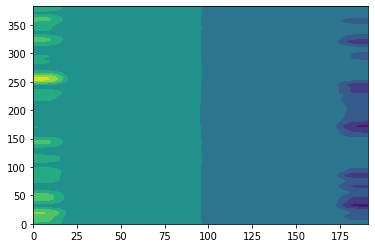

In [46]:
plt.contourf(noise)

In [47]:
#Integration parameters
solver.stop_sim_time  = stop_sim_time
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

In [48]:
#Analysis
#define the destination for storage 
shutil.rmtree('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots', ignore_errors=True)
snapshots = solver.evaluator.add_file_handler('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots',sim_dt=5e-5,max_writes=200,mode=fh_mode)
snapshots.add_task("integ(T,'x')/xres", layout='g', name='<Tx>')
snapshots.add_task("0.5 * (u ** 2 + w ** 2)", layout='g', name='KE')
snapshots.add_task("sqrt(u ** 2 + w ** 2)", layout='g', name='|uvec|')
snapshots.add_system(solver.state)

In [49]:
#CFL (don't touch it)
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=0.5, max_change=1.5, min_change=1, max_dt=1e-7, threshold=0.05)
CFL.add_velocities(('u', 'w'))

flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u ** 2 + w ** 2)/Ra", name='Re')

In [50]:
# Main loop 
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.proceed:
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 100 == 0:
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f minutes' %((end_time-start_time)/60))

INFO:2D RB Convection:Starting loop


2022-09-18 23:09:07,139 2D RB Convection 0/1 INFO :: Starting loop


DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (complex128, (192, 288), 1)
DEBUG:basis:Building FFTW FFT plan for (dtype, gshape, axis) = (float64, (576, 288), 0)
DEBUG:h5py._conv:Creating converter from 5 to 3
INFO:2D RB Convection:Iteration: 1, Time: 5.000000e-08, dt: 5.000000e-08


2022-09-18 23:09:07,911 2D RB Convection 0/1 INFO :: Iteration: 1, Time: 5.000000e-08, dt: 5.000000e-08


INFO:2D RB Convection:Iteration: 101, Time: 9.300000e-06, dt: 1.000000e-07


2022-09-18 23:09:19,395 2D RB Convection 0/1 INFO :: Iteration: 101, Time: 9.300000e-06, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 201, Time: 1.930000e-05, dt: 1.000000e-07


2022-09-18 23:09:29,887 2D RB Convection 0/1 INFO :: Iteration: 201, Time: 1.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 301, Time: 2.930000e-05, dt: 1.000000e-07


2022-09-18 23:09:40,359 2D RB Convection 0/1 INFO :: Iteration: 301, Time: 2.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 401, Time: 3.930000e-05, dt: 1.000000e-07


2022-09-18 23:09:50,812 2D RB Convection 0/1 INFO :: Iteration: 401, Time: 3.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 501, Time: 4.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:01,306 2D RB Convection 0/1 INFO :: Iteration: 501, Time: 4.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 601, Time: 5.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:12,222 2D RB Convection 0/1 INFO :: Iteration: 601, Time: 5.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 701, Time: 6.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:22,712 2D RB Convection 0/1 INFO :: Iteration: 701, Time: 6.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 801, Time: 7.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:33,161 2D RB Convection 0/1 INFO :: Iteration: 801, Time: 7.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 901, Time: 8.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:43,629 2D RB Convection 0/1 INFO :: Iteration: 901, Time: 8.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1001, Time: 9.930000e-05, dt: 1.000000e-07


2022-09-18 23:10:54,047 2D RB Convection 0/1 INFO :: Iteration: 1001, Time: 9.930000e-05, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1101, Time: 1.093000e-04, dt: 1.000000e-07


2022-09-18 23:11:04,859 2D RB Convection 0/1 INFO :: Iteration: 1101, Time: 1.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1201, Time: 1.193000e-04, dt: 1.000000e-07


2022-09-18 23:11:15,345 2D RB Convection 0/1 INFO :: Iteration: 1201, Time: 1.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1301, Time: 1.293000e-04, dt: 1.000000e-07


2022-09-18 23:11:25,831 2D RB Convection 0/1 INFO :: Iteration: 1301, Time: 1.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1401, Time: 1.393000e-04, dt: 1.000000e-07


2022-09-18 23:11:36,348 2D RB Convection 0/1 INFO :: Iteration: 1401, Time: 1.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1501, Time: 1.493000e-04, dt: 1.000000e-07


2022-09-18 23:11:46,804 2D RB Convection 0/1 INFO :: Iteration: 1501, Time: 1.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1601, Time: 1.593000e-04, dt: 1.000000e-07


2022-09-18 23:11:57,578 2D RB Convection 0/1 INFO :: Iteration: 1601, Time: 1.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1701, Time: 1.693000e-04, dt: 1.000000e-07


2022-09-18 23:12:08,047 2D RB Convection 0/1 INFO :: Iteration: 1701, Time: 1.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1801, Time: 1.793000e-04, dt: 1.000000e-07


2022-09-18 23:12:18,536 2D RB Convection 0/1 INFO :: Iteration: 1801, Time: 1.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 1901, Time: 1.893000e-04, dt: 1.000000e-07


2022-09-18 23:12:29,001 2D RB Convection 0/1 INFO :: Iteration: 1901, Time: 1.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2001, Time: 1.993000e-04, dt: 1.000000e-07


2022-09-18 23:12:39,437 2D RB Convection 0/1 INFO :: Iteration: 2001, Time: 1.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2101, Time: 2.093000e-04, dt: 1.000000e-07


2022-09-18 23:12:50,222 2D RB Convection 0/1 INFO :: Iteration: 2101, Time: 2.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2201, Time: 2.193000e-04, dt: 1.000000e-07


2022-09-18 23:13:00,700 2D RB Convection 0/1 INFO :: Iteration: 2201, Time: 2.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2301, Time: 2.293000e-04, dt: 1.000000e-07


2022-09-18 23:13:11,237 2D RB Convection 0/1 INFO :: Iteration: 2301, Time: 2.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2401, Time: 2.393000e-04, dt: 1.000000e-07


2022-09-18 23:13:21,763 2D RB Convection 0/1 INFO :: Iteration: 2401, Time: 2.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2501, Time: 2.493000e-04, dt: 1.000000e-07


2022-09-18 23:13:32,211 2D RB Convection 0/1 INFO :: Iteration: 2501, Time: 2.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2601, Time: 2.593000e-04, dt: 1.000000e-07


2022-09-18 23:13:42,919 2D RB Convection 0/1 INFO :: Iteration: 2601, Time: 2.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2701, Time: 2.693000e-04, dt: 1.000000e-07


2022-09-18 23:13:53,387 2D RB Convection 0/1 INFO :: Iteration: 2701, Time: 2.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2801, Time: 2.793000e-04, dt: 1.000000e-07


2022-09-18 23:14:03,851 2D RB Convection 0/1 INFO :: Iteration: 2801, Time: 2.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 2901, Time: 2.893000e-04, dt: 1.000000e-07


2022-09-18 23:14:14,342 2D RB Convection 0/1 INFO :: Iteration: 2901, Time: 2.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3001, Time: 2.993000e-04, dt: 1.000000e-07


2022-09-18 23:14:24,811 2D RB Convection 0/1 INFO :: Iteration: 3001, Time: 2.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3101, Time: 3.093000e-04, dt: 1.000000e-07


2022-09-18 23:14:35,634 2D RB Convection 0/1 INFO :: Iteration: 3101, Time: 3.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3201, Time: 3.193000e-04, dt: 1.000000e-07


2022-09-18 23:14:46,144 2D RB Convection 0/1 INFO :: Iteration: 3201, Time: 3.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3301, Time: 3.293000e-04, dt: 1.000000e-07


2022-09-18 23:14:56,626 2D RB Convection 0/1 INFO :: Iteration: 3301, Time: 3.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3401, Time: 3.393000e-04, dt: 1.000000e-07


2022-09-18 23:15:07,082 2D RB Convection 0/1 INFO :: Iteration: 3401, Time: 3.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3501, Time: 3.493000e-04, dt: 1.000000e-07


2022-09-18 23:15:17,589 2D RB Convection 0/1 INFO :: Iteration: 3501, Time: 3.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3601, Time: 3.593000e-04, dt: 1.000000e-07


2022-09-18 23:15:28,474 2D RB Convection 0/1 INFO :: Iteration: 3601, Time: 3.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3701, Time: 3.693000e-04, dt: 1.000000e-07


2022-09-18 23:15:38,968 2D RB Convection 0/1 INFO :: Iteration: 3701, Time: 3.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3801, Time: 3.793000e-04, dt: 1.000000e-07


2022-09-18 23:15:49,398 2D RB Convection 0/1 INFO :: Iteration: 3801, Time: 3.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 3901, Time: 3.893000e-04, dt: 1.000000e-07


2022-09-18 23:15:59,868 2D RB Convection 0/1 INFO :: Iteration: 3901, Time: 3.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4001, Time: 3.993000e-04, dt: 1.000000e-07


2022-09-18 23:16:10,338 2D RB Convection 0/1 INFO :: Iteration: 4001, Time: 3.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4101, Time: 4.093000e-04, dt: 1.000000e-07


2022-09-18 23:16:21,176 2D RB Convection 0/1 INFO :: Iteration: 4101, Time: 4.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4201, Time: 4.193000e-04, dt: 1.000000e-07


2022-09-18 23:16:31,692 2D RB Convection 0/1 INFO :: Iteration: 4201, Time: 4.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4301, Time: 4.293000e-04, dt: 1.000000e-07


2022-09-18 23:16:42,180 2D RB Convection 0/1 INFO :: Iteration: 4301, Time: 4.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4401, Time: 4.393000e-04, dt: 1.000000e-07


2022-09-18 23:16:52,630 2D RB Convection 0/1 INFO :: Iteration: 4401, Time: 4.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4501, Time: 4.493000e-04, dt: 1.000000e-07


2022-09-18 23:17:03,060 2D RB Convection 0/1 INFO :: Iteration: 4501, Time: 4.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4601, Time: 4.593000e-04, dt: 1.000000e-07


2022-09-18 23:17:13,825 2D RB Convection 0/1 INFO :: Iteration: 4601, Time: 4.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4701, Time: 4.693000e-04, dt: 1.000000e-07


2022-09-18 23:17:24,208 2D RB Convection 0/1 INFO :: Iteration: 4701, Time: 4.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4801, Time: 4.793000e-04, dt: 1.000000e-07


2022-09-18 23:17:34,689 2D RB Convection 0/1 INFO :: Iteration: 4801, Time: 4.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 4901, Time: 4.893000e-04, dt: 1.000000e-07


2022-09-18 23:17:45,084 2D RB Convection 0/1 INFO :: Iteration: 4901, Time: 4.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5001, Time: 4.993000e-04, dt: 1.000000e-07


2022-09-18 23:17:55,536 2D RB Convection 0/1 INFO :: Iteration: 5001, Time: 4.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5101, Time: 5.093000e-04, dt: 1.000000e-07


2022-09-18 23:18:06,383 2D RB Convection 0/1 INFO :: Iteration: 5101, Time: 5.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5201, Time: 5.193000e-04, dt: 1.000000e-07


2022-09-18 23:18:16,895 2D RB Convection 0/1 INFO :: Iteration: 5201, Time: 5.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5301, Time: 5.293000e-04, dt: 1.000000e-07


2022-09-18 23:18:27,355 2D RB Convection 0/1 INFO :: Iteration: 5301, Time: 5.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5401, Time: 5.393000e-04, dt: 1.000000e-07


2022-09-18 23:18:37,791 2D RB Convection 0/1 INFO :: Iteration: 5401, Time: 5.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5501, Time: 5.493000e-04, dt: 1.000000e-07


2022-09-18 23:18:48,170 2D RB Convection 0/1 INFO :: Iteration: 5501, Time: 5.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5601, Time: 5.593000e-04, dt: 1.000000e-07


2022-09-18 23:18:58,916 2D RB Convection 0/1 INFO :: Iteration: 5601, Time: 5.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5701, Time: 5.693000e-04, dt: 1.000000e-07


2022-09-18 23:19:09,396 2D RB Convection 0/1 INFO :: Iteration: 5701, Time: 5.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5801, Time: 5.793000e-04, dt: 1.000000e-07


2022-09-18 23:19:19,829 2D RB Convection 0/1 INFO :: Iteration: 5801, Time: 5.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 5901, Time: 5.893000e-04, dt: 1.000000e-07


2022-09-18 23:19:30,321 2D RB Convection 0/1 INFO :: Iteration: 5901, Time: 5.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6001, Time: 5.993000e-04, dt: 1.000000e-07


2022-09-18 23:19:40,803 2D RB Convection 0/1 INFO :: Iteration: 6001, Time: 5.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6101, Time: 6.093000e-04, dt: 1.000000e-07


2022-09-18 23:19:51,590 2D RB Convection 0/1 INFO :: Iteration: 6101, Time: 6.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6201, Time: 6.193000e-04, dt: 1.000000e-07


2022-09-18 23:20:02,040 2D RB Convection 0/1 INFO :: Iteration: 6201, Time: 6.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6301, Time: 6.293000e-04, dt: 1.000000e-07


2022-09-18 23:20:12,533 2D RB Convection 0/1 INFO :: Iteration: 6301, Time: 6.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6401, Time: 6.393000e-04, dt: 1.000000e-07


2022-09-18 23:20:22,983 2D RB Convection 0/1 INFO :: Iteration: 6401, Time: 6.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6501, Time: 6.493000e-04, dt: 1.000000e-07


2022-09-18 23:20:33,438 2D RB Convection 0/1 INFO :: Iteration: 6501, Time: 6.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6601, Time: 6.593000e-04, dt: 1.000000e-07


2022-09-18 23:20:44,208 2D RB Convection 0/1 INFO :: Iteration: 6601, Time: 6.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6701, Time: 6.693000e-04, dt: 1.000000e-07


2022-09-18 23:20:54,627 2D RB Convection 0/1 INFO :: Iteration: 6701, Time: 6.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6801, Time: 6.793000e-04, dt: 1.000000e-07


2022-09-18 23:21:05,111 2D RB Convection 0/1 INFO :: Iteration: 6801, Time: 6.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 6901, Time: 6.893000e-04, dt: 1.000000e-07


2022-09-18 23:21:15,510 2D RB Convection 0/1 INFO :: Iteration: 6901, Time: 6.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7001, Time: 6.993000e-04, dt: 1.000000e-07


2022-09-18 23:21:25,967 2D RB Convection 0/1 INFO :: Iteration: 7001, Time: 6.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7101, Time: 7.093000e-04, dt: 1.000000e-07


2022-09-18 23:21:36,883 2D RB Convection 0/1 INFO :: Iteration: 7101, Time: 7.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7201, Time: 7.193000e-04, dt: 1.000000e-07


2022-09-18 23:21:47,327 2D RB Convection 0/1 INFO :: Iteration: 7201, Time: 7.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7301, Time: 7.293000e-04, dt: 1.000000e-07


2022-09-18 23:21:57,743 2D RB Convection 0/1 INFO :: Iteration: 7301, Time: 7.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7401, Time: 7.393000e-04, dt: 1.000000e-07


2022-09-18 23:22:08,164 2D RB Convection 0/1 INFO :: Iteration: 7401, Time: 7.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7501, Time: 7.493000e-04, dt: 1.000000e-07


2022-09-18 23:22:18,655 2D RB Convection 0/1 INFO :: Iteration: 7501, Time: 7.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7601, Time: 7.593000e-04, dt: 1.000000e-07


2022-09-18 23:22:29,496 2D RB Convection 0/1 INFO :: Iteration: 7601, Time: 7.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7701, Time: 7.693000e-04, dt: 1.000000e-07


2022-09-18 23:22:39,907 2D RB Convection 0/1 INFO :: Iteration: 7701, Time: 7.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7801, Time: 7.793000e-04, dt: 1.000000e-07


2022-09-18 23:22:50,307 2D RB Convection 0/1 INFO :: Iteration: 7801, Time: 7.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 7901, Time: 7.893000e-04, dt: 1.000000e-07


2022-09-18 23:23:00,724 2D RB Convection 0/1 INFO :: Iteration: 7901, Time: 7.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8001, Time: 7.993000e-04, dt: 1.000000e-07


2022-09-18 23:23:11,123 2D RB Convection 0/1 INFO :: Iteration: 8001, Time: 7.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8101, Time: 8.093000e-04, dt: 1.000000e-07


2022-09-18 23:23:21,985 2D RB Convection 0/1 INFO :: Iteration: 8101, Time: 8.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8201, Time: 8.193000e-04, dt: 1.000000e-07


2022-09-18 23:23:32,377 2D RB Convection 0/1 INFO :: Iteration: 8201, Time: 8.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8301, Time: 8.293000e-04, dt: 1.000000e-07


2022-09-18 23:23:42,838 2D RB Convection 0/1 INFO :: Iteration: 8301, Time: 8.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8401, Time: 8.393000e-04, dt: 1.000000e-07


2022-09-18 23:23:53,239 2D RB Convection 0/1 INFO :: Iteration: 8401, Time: 8.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8501, Time: 8.493000e-04, dt: 1.000000e-07


2022-09-18 23:24:03,655 2D RB Convection 0/1 INFO :: Iteration: 8501, Time: 8.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8601, Time: 8.593000e-04, dt: 1.000000e-07


2022-09-18 23:24:14,393 2D RB Convection 0/1 INFO :: Iteration: 8601, Time: 8.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8701, Time: 8.693000e-04, dt: 1.000000e-07


2022-09-18 23:24:24,845 2D RB Convection 0/1 INFO :: Iteration: 8701, Time: 8.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8801, Time: 8.793000e-04, dt: 1.000000e-07


2022-09-18 23:24:35,299 2D RB Convection 0/1 INFO :: Iteration: 8801, Time: 8.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 8901, Time: 8.893000e-04, dt: 1.000000e-07


2022-09-18 23:24:45,725 2D RB Convection 0/1 INFO :: Iteration: 8901, Time: 8.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9001, Time: 8.993000e-04, dt: 1.000000e-07


2022-09-18 23:24:56,170 2D RB Convection 0/1 INFO :: Iteration: 9001, Time: 8.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9101, Time: 9.093000e-04, dt: 1.000000e-07


2022-09-18 23:25:07,029 2D RB Convection 0/1 INFO :: Iteration: 9101, Time: 9.093000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9201, Time: 9.193000e-04, dt: 1.000000e-07


2022-09-18 23:25:17,449 2D RB Convection 0/1 INFO :: Iteration: 9201, Time: 9.193000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9301, Time: 9.293000e-04, dt: 1.000000e-07


2022-09-18 23:25:27,826 2D RB Convection 0/1 INFO :: Iteration: 9301, Time: 9.293000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9401, Time: 9.393000e-04, dt: 1.000000e-07


2022-09-18 23:25:38,278 2D RB Convection 0/1 INFO :: Iteration: 9401, Time: 9.393000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9501, Time: 9.493000e-04, dt: 1.000000e-07


2022-09-18 23:25:48,689 2D RB Convection 0/1 INFO :: Iteration: 9501, Time: 9.493000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9601, Time: 9.593000e-04, dt: 1.000000e-07


2022-09-18 23:25:59,576 2D RB Convection 0/1 INFO :: Iteration: 9601, Time: 9.593000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9701, Time: 9.693000e-04, dt: 1.000000e-07


2022-09-18 23:26:10,061 2D RB Convection 0/1 INFO :: Iteration: 9701, Time: 9.693000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9801, Time: 9.793000e-04, dt: 1.000000e-07


2022-09-18 23:26:20,509 2D RB Convection 0/1 INFO :: Iteration: 9801, Time: 9.793000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 9901, Time: 9.893000e-04, dt: 1.000000e-07


2022-09-18 23:26:30,977 2D RB Convection 0/1 INFO :: Iteration: 9901, Time: 9.893000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10001, Time: 9.993000e-04, dt: 1.000000e-07


2022-09-18 23:26:41,445 2D RB Convection 0/1 INFO :: Iteration: 10001, Time: 9.993000e-04, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10101, Time: 1.009300e-03, dt: 1.000000e-07


2022-09-18 23:26:52,189 2D RB Convection 0/1 INFO :: Iteration: 10101, Time: 1.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10201, Time: 1.019300e-03, dt: 1.000000e-07


2022-09-18 23:27:02,629 2D RB Convection 0/1 INFO :: Iteration: 10201, Time: 1.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10301, Time: 1.029300e-03, dt: 1.000000e-07


2022-09-18 23:27:13,067 2D RB Convection 0/1 INFO :: Iteration: 10301, Time: 1.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10401, Time: 1.039300e-03, dt: 1.000000e-07


2022-09-18 23:27:23,492 2D RB Convection 0/1 INFO :: Iteration: 10401, Time: 1.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10501, Time: 1.049300e-03, dt: 1.000000e-07


2022-09-18 23:27:33,910 2D RB Convection 0/1 INFO :: Iteration: 10501, Time: 1.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10601, Time: 1.059300e-03, dt: 1.000000e-07


2022-09-18 23:27:44,869 2D RB Convection 0/1 INFO :: Iteration: 10601, Time: 1.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10701, Time: 1.069300e-03, dt: 1.000000e-07


2022-09-18 23:27:55,293 2D RB Convection 0/1 INFO :: Iteration: 10701, Time: 1.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10801, Time: 1.079300e-03, dt: 1.000000e-07


2022-09-18 23:28:05,720 2D RB Convection 0/1 INFO :: Iteration: 10801, Time: 1.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 10901, Time: 1.089300e-03, dt: 1.000000e-07


2022-09-18 23:28:16,164 2D RB Convection 0/1 INFO :: Iteration: 10901, Time: 1.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11001, Time: 1.099300e-03, dt: 1.000000e-07


2022-09-18 23:28:26,555 2D RB Convection 0/1 INFO :: Iteration: 11001, Time: 1.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11101, Time: 1.109300e-03, dt: 1.000000e-07


2022-09-18 23:28:37,339 2D RB Convection 0/1 INFO :: Iteration: 11101, Time: 1.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11201, Time: 1.119300e-03, dt: 1.000000e-07


2022-09-18 23:28:47,761 2D RB Convection 0/1 INFO :: Iteration: 11201, Time: 1.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11301, Time: 1.129300e-03, dt: 1.000000e-07


2022-09-18 23:28:58,155 2D RB Convection 0/1 INFO :: Iteration: 11301, Time: 1.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11401, Time: 1.139300e-03, dt: 1.000000e-07


2022-09-18 23:29:08,581 2D RB Convection 0/1 INFO :: Iteration: 11401, Time: 1.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11501, Time: 1.149300e-03, dt: 1.000000e-07


2022-09-18 23:29:19,043 2D RB Convection 0/1 INFO :: Iteration: 11501, Time: 1.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11601, Time: 1.159300e-03, dt: 1.000000e-07


2022-09-18 23:29:29,828 2D RB Convection 0/1 INFO :: Iteration: 11601, Time: 1.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11701, Time: 1.169300e-03, dt: 1.000000e-07


2022-09-18 23:29:40,208 2D RB Convection 0/1 INFO :: Iteration: 11701, Time: 1.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11801, Time: 1.179300e-03, dt: 1.000000e-07


2022-09-18 23:29:50,609 2D RB Convection 0/1 INFO :: Iteration: 11801, Time: 1.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 11901, Time: 1.189300e-03, dt: 1.000000e-07


2022-09-18 23:30:00,970 2D RB Convection 0/1 INFO :: Iteration: 11901, Time: 1.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12001, Time: 1.199300e-03, dt: 1.000000e-07


2022-09-18 23:30:11,420 2D RB Convection 0/1 INFO :: Iteration: 12001, Time: 1.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12101, Time: 1.209300e-03, dt: 1.000000e-07


2022-09-18 23:30:22,300 2D RB Convection 0/1 INFO :: Iteration: 12101, Time: 1.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12201, Time: 1.219300e-03, dt: 1.000000e-07


2022-09-18 23:30:32,801 2D RB Convection 0/1 INFO :: Iteration: 12201, Time: 1.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12301, Time: 1.229300e-03, dt: 1.000000e-07


2022-09-18 23:30:43,224 2D RB Convection 0/1 INFO :: Iteration: 12301, Time: 1.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12401, Time: 1.239300e-03, dt: 1.000000e-07


2022-09-18 23:30:53,659 2D RB Convection 0/1 INFO :: Iteration: 12401, Time: 1.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12501, Time: 1.249300e-03, dt: 1.000000e-07


2022-09-18 23:31:04,177 2D RB Convection 0/1 INFO :: Iteration: 12501, Time: 1.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12601, Time: 1.259300e-03, dt: 1.000000e-07


2022-09-18 23:31:15,055 2D RB Convection 0/1 INFO :: Iteration: 12601, Time: 1.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12701, Time: 1.269300e-03, dt: 1.000000e-07


2022-09-18 23:31:25,607 2D RB Convection 0/1 INFO :: Iteration: 12701, Time: 1.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12801, Time: 1.279300e-03, dt: 1.000000e-07


2022-09-18 23:31:36,200 2D RB Convection 0/1 INFO :: Iteration: 12801, Time: 1.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 12901, Time: 1.289300e-03, dt: 1.000000e-07


2022-09-18 23:31:46,774 2D RB Convection 0/1 INFO :: Iteration: 12901, Time: 1.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13001, Time: 1.299300e-03, dt: 1.000000e-07


2022-09-18 23:31:57,219 2D RB Convection 0/1 INFO :: Iteration: 13001, Time: 1.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13101, Time: 1.309300e-03, dt: 1.000000e-07


2022-09-18 23:32:08,139 2D RB Convection 0/1 INFO :: Iteration: 13101, Time: 1.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13201, Time: 1.319300e-03, dt: 1.000000e-07


2022-09-18 23:32:18,599 2D RB Convection 0/1 INFO :: Iteration: 13201, Time: 1.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13301, Time: 1.329300e-03, dt: 1.000000e-07


2022-09-18 23:32:29,013 2D RB Convection 0/1 INFO :: Iteration: 13301, Time: 1.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13401, Time: 1.339300e-03, dt: 1.000000e-07


2022-09-18 23:32:39,430 2D RB Convection 0/1 INFO :: Iteration: 13401, Time: 1.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13501, Time: 1.349300e-03, dt: 1.000000e-07


2022-09-18 23:32:49,801 2D RB Convection 0/1 INFO :: Iteration: 13501, Time: 1.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13601, Time: 1.359300e-03, dt: 1.000000e-07


2022-09-18 23:33:00,731 2D RB Convection 0/1 INFO :: Iteration: 13601, Time: 1.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13701, Time: 1.369300e-03, dt: 1.000000e-07


2022-09-18 23:33:11,192 2D RB Convection 0/1 INFO :: Iteration: 13701, Time: 1.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13801, Time: 1.379300e-03, dt: 1.000000e-07


2022-09-18 23:33:21,599 2D RB Convection 0/1 INFO :: Iteration: 13801, Time: 1.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 13901, Time: 1.389300e-03, dt: 1.000000e-07


2022-09-18 23:33:32,003 2D RB Convection 0/1 INFO :: Iteration: 13901, Time: 1.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14001, Time: 1.399300e-03, dt: 1.000000e-07


2022-09-18 23:33:42,405 2D RB Convection 0/1 INFO :: Iteration: 14001, Time: 1.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14101, Time: 1.409300e-03, dt: 1.000000e-07


2022-09-18 23:33:53,254 2D RB Convection 0/1 INFO :: Iteration: 14101, Time: 1.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14201, Time: 1.419300e-03, dt: 1.000000e-07


2022-09-18 23:34:03,634 2D RB Convection 0/1 INFO :: Iteration: 14201, Time: 1.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14301, Time: 1.429300e-03, dt: 1.000000e-07


2022-09-18 23:34:13,998 2D RB Convection 0/1 INFO :: Iteration: 14301, Time: 1.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14401, Time: 1.439300e-03, dt: 1.000000e-07


2022-09-18 23:34:24,347 2D RB Convection 0/1 INFO :: Iteration: 14401, Time: 1.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14501, Time: 1.449300e-03, dt: 1.000000e-07


2022-09-18 23:34:34,751 2D RB Convection 0/1 INFO :: Iteration: 14501, Time: 1.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14601, Time: 1.459300e-03, dt: 1.000000e-07


2022-09-18 23:34:45,671 2D RB Convection 0/1 INFO :: Iteration: 14601, Time: 1.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14701, Time: 1.469300e-03, dt: 1.000000e-07


2022-09-18 23:34:56,096 2D RB Convection 0/1 INFO :: Iteration: 14701, Time: 1.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14801, Time: 1.479300e-03, dt: 1.000000e-07


2022-09-18 23:35:06,478 2D RB Convection 0/1 INFO :: Iteration: 14801, Time: 1.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 14901, Time: 1.489300e-03, dt: 1.000000e-07


2022-09-18 23:35:16,932 2D RB Convection 0/1 INFO :: Iteration: 14901, Time: 1.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15001, Time: 1.499300e-03, dt: 1.000000e-07


2022-09-18 23:35:27,365 2D RB Convection 0/1 INFO :: Iteration: 15001, Time: 1.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15101, Time: 1.509300e-03, dt: 1.000000e-07


2022-09-18 23:35:38,525 2D RB Convection 0/1 INFO :: Iteration: 15101, Time: 1.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15201, Time: 1.519300e-03, dt: 1.000000e-07


2022-09-18 23:35:48,950 2D RB Convection 0/1 INFO :: Iteration: 15201, Time: 1.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15301, Time: 1.529300e-03, dt: 1.000000e-07


2022-09-18 23:35:59,341 2D RB Convection 0/1 INFO :: Iteration: 15301, Time: 1.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15401, Time: 1.539300e-03, dt: 1.000000e-07


2022-09-18 23:36:09,727 2D RB Convection 0/1 INFO :: Iteration: 15401, Time: 1.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15501, Time: 1.549300e-03, dt: 1.000000e-07


2022-09-18 23:36:20,088 2D RB Convection 0/1 INFO :: Iteration: 15501, Time: 1.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15601, Time: 1.559300e-03, dt: 1.000000e-07


2022-09-18 23:36:31,164 2D RB Convection 0/1 INFO :: Iteration: 15601, Time: 1.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15701, Time: 1.569300e-03, dt: 1.000000e-07


2022-09-18 23:36:41,578 2D RB Convection 0/1 INFO :: Iteration: 15701, Time: 1.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15801, Time: 1.579300e-03, dt: 1.000000e-07


2022-09-18 23:36:51,991 2D RB Convection 0/1 INFO :: Iteration: 15801, Time: 1.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 15901, Time: 1.589300e-03, dt: 1.000000e-07


2022-09-18 23:37:02,407 2D RB Convection 0/1 INFO :: Iteration: 15901, Time: 1.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16001, Time: 1.599300e-03, dt: 1.000000e-07


2022-09-18 23:37:12,880 2D RB Convection 0/1 INFO :: Iteration: 16001, Time: 1.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16101, Time: 1.609300e-03, dt: 1.000000e-07


2022-09-18 23:37:23,602 2D RB Convection 0/1 INFO :: Iteration: 16101, Time: 1.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16201, Time: 1.619300e-03, dt: 1.000000e-07


2022-09-18 23:37:33,991 2D RB Convection 0/1 INFO :: Iteration: 16201, Time: 1.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16301, Time: 1.629300e-03, dt: 1.000000e-07


2022-09-18 23:37:44,354 2D RB Convection 0/1 INFO :: Iteration: 16301, Time: 1.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16401, Time: 1.639300e-03, dt: 1.000000e-07


2022-09-18 23:37:54,748 2D RB Convection 0/1 INFO :: Iteration: 16401, Time: 1.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16501, Time: 1.649300e-03, dt: 1.000000e-07


2022-09-18 23:38:05,110 2D RB Convection 0/1 INFO :: Iteration: 16501, Time: 1.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16601, Time: 1.659300e-03, dt: 1.000000e-07


2022-09-18 23:38:15,999 2D RB Convection 0/1 INFO :: Iteration: 16601, Time: 1.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16701, Time: 1.669300e-03, dt: 1.000000e-07


2022-09-18 23:38:26,420 2D RB Convection 0/1 INFO :: Iteration: 16701, Time: 1.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16801, Time: 1.679300e-03, dt: 1.000000e-07


2022-09-18 23:38:36,849 2D RB Convection 0/1 INFO :: Iteration: 16801, Time: 1.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 16901, Time: 1.689300e-03, dt: 1.000000e-07


2022-09-18 23:38:47,278 2D RB Convection 0/1 INFO :: Iteration: 16901, Time: 1.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17001, Time: 1.699300e-03, dt: 1.000000e-07


2022-09-18 23:38:57,647 2D RB Convection 0/1 INFO :: Iteration: 17001, Time: 1.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17101, Time: 1.709300e-03, dt: 1.000000e-07


2022-09-18 23:39:08,603 2D RB Convection 0/1 INFO :: Iteration: 17101, Time: 1.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17201, Time: 1.719300e-03, dt: 1.000000e-07


2022-09-18 23:39:19,027 2D RB Convection 0/1 INFO :: Iteration: 17201, Time: 1.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17301, Time: 1.729300e-03, dt: 1.000000e-07


2022-09-18 23:39:29,404 2D RB Convection 0/1 INFO :: Iteration: 17301, Time: 1.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17401, Time: 1.739300e-03, dt: 1.000000e-07


2022-09-18 23:39:39,835 2D RB Convection 0/1 INFO :: Iteration: 17401, Time: 1.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17501, Time: 1.749300e-03, dt: 1.000000e-07


2022-09-18 23:39:50,239 2D RB Convection 0/1 INFO :: Iteration: 17501, Time: 1.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17601, Time: 1.759300e-03, dt: 1.000000e-07


2022-09-18 23:40:01,069 2D RB Convection 0/1 INFO :: Iteration: 17601, Time: 1.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17701, Time: 1.769300e-03, dt: 1.000000e-07


2022-09-18 23:40:11,500 2D RB Convection 0/1 INFO :: Iteration: 17701, Time: 1.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17801, Time: 1.779300e-03, dt: 1.000000e-07


2022-09-18 23:40:21,926 2D RB Convection 0/1 INFO :: Iteration: 17801, Time: 1.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 17901, Time: 1.789300e-03, dt: 1.000000e-07


2022-09-18 23:40:32,377 2D RB Convection 0/1 INFO :: Iteration: 17901, Time: 1.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18001, Time: 1.799300e-03, dt: 1.000000e-07


2022-09-18 23:40:42,804 2D RB Convection 0/1 INFO :: Iteration: 18001, Time: 1.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18101, Time: 1.809300e-03, dt: 1.000000e-07


2022-09-18 23:40:53,831 2D RB Convection 0/1 INFO :: Iteration: 18101, Time: 1.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18201, Time: 1.819300e-03, dt: 1.000000e-07


2022-09-18 23:41:04,256 2D RB Convection 0/1 INFO :: Iteration: 18201, Time: 1.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18301, Time: 1.829300e-03, dt: 1.000000e-07


2022-09-18 23:41:14,690 2D RB Convection 0/1 INFO :: Iteration: 18301, Time: 1.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18401, Time: 1.839300e-03, dt: 1.000000e-07


2022-09-18 23:41:25,107 2D RB Convection 0/1 INFO :: Iteration: 18401, Time: 1.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18501, Time: 1.849300e-03, dt: 1.000000e-07


2022-09-18 23:41:35,555 2D RB Convection 0/1 INFO :: Iteration: 18501, Time: 1.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18601, Time: 1.859300e-03, dt: 1.000000e-07


2022-09-18 23:41:46,379 2D RB Convection 0/1 INFO :: Iteration: 18601, Time: 1.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18701, Time: 1.869300e-03, dt: 1.000000e-07


2022-09-18 23:41:56,815 2D RB Convection 0/1 INFO :: Iteration: 18701, Time: 1.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18801, Time: 1.879300e-03, dt: 1.000000e-07


2022-09-18 23:42:07,267 2D RB Convection 0/1 INFO :: Iteration: 18801, Time: 1.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 18901, Time: 1.889300e-03, dt: 1.000000e-07


2022-09-18 23:42:17,692 2D RB Convection 0/1 INFO :: Iteration: 18901, Time: 1.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19001, Time: 1.899300e-03, dt: 1.000000e-07


2022-09-18 23:42:28,072 2D RB Convection 0/1 INFO :: Iteration: 19001, Time: 1.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19101, Time: 1.909300e-03, dt: 1.000000e-07


2022-09-18 23:42:38,981 2D RB Convection 0/1 INFO :: Iteration: 19101, Time: 1.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19201, Time: 1.919300e-03, dt: 1.000000e-07


2022-09-18 23:42:49,374 2D RB Convection 0/1 INFO :: Iteration: 19201, Time: 1.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19301, Time: 1.929300e-03, dt: 1.000000e-07


2022-09-18 23:42:59,771 2D RB Convection 0/1 INFO :: Iteration: 19301, Time: 1.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19401, Time: 1.939300e-03, dt: 1.000000e-07


2022-09-18 23:43:10,186 2D RB Convection 0/1 INFO :: Iteration: 19401, Time: 1.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19501, Time: 1.949300e-03, dt: 1.000000e-07


2022-09-18 23:43:20,587 2D RB Convection 0/1 INFO :: Iteration: 19501, Time: 1.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19601, Time: 1.959300e-03, dt: 1.000000e-07


2022-09-18 23:43:31,387 2D RB Convection 0/1 INFO :: Iteration: 19601, Time: 1.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19701, Time: 1.969300e-03, dt: 1.000000e-07


2022-09-18 23:43:41,806 2D RB Convection 0/1 INFO :: Iteration: 19701, Time: 1.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19801, Time: 1.979300e-03, dt: 1.000000e-07


2022-09-18 23:43:52,195 2D RB Convection 0/1 INFO :: Iteration: 19801, Time: 1.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 19901, Time: 1.989300e-03, dt: 1.000000e-07


2022-09-18 23:44:02,588 2D RB Convection 0/1 INFO :: Iteration: 19901, Time: 1.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20001, Time: 1.999300e-03, dt: 1.000000e-07


2022-09-18 23:44:13,009 2D RB Convection 0/1 INFO :: Iteration: 20001, Time: 1.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20101, Time: 2.009300e-03, dt: 1.000000e-07


2022-09-18 23:44:24,029 2D RB Convection 0/1 INFO :: Iteration: 20101, Time: 2.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20201, Time: 2.019300e-03, dt: 1.000000e-07


2022-09-18 23:44:34,422 2D RB Convection 0/1 INFO :: Iteration: 20201, Time: 2.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20301, Time: 2.029300e-03, dt: 1.000000e-07


2022-09-18 23:44:44,786 2D RB Convection 0/1 INFO :: Iteration: 20301, Time: 2.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20401, Time: 2.039300e-03, dt: 1.000000e-07


2022-09-18 23:44:55,145 2D RB Convection 0/1 INFO :: Iteration: 20401, Time: 2.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20501, Time: 2.049300e-03, dt: 1.000000e-07


2022-09-18 23:45:05,539 2D RB Convection 0/1 INFO :: Iteration: 20501, Time: 2.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20601, Time: 2.059300e-03, dt: 1.000000e-07


2022-09-18 23:45:16,567 2D RB Convection 0/1 INFO :: Iteration: 20601, Time: 2.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20701, Time: 2.069300e-03, dt: 1.000000e-07


2022-09-18 23:45:26,985 2D RB Convection 0/1 INFO :: Iteration: 20701, Time: 2.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20801, Time: 2.079300e-03, dt: 1.000000e-07


2022-09-18 23:45:37,436 2D RB Convection 0/1 INFO :: Iteration: 20801, Time: 2.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 20901, Time: 2.089300e-03, dt: 1.000000e-07


2022-09-18 23:45:47,799 2D RB Convection 0/1 INFO :: Iteration: 20901, Time: 2.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21001, Time: 2.099300e-03, dt: 1.000000e-07


2022-09-18 23:45:58,177 2D RB Convection 0/1 INFO :: Iteration: 21001, Time: 2.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21101, Time: 2.109300e-03, dt: 1.000000e-07


2022-09-18 23:46:08,963 2D RB Convection 0/1 INFO :: Iteration: 21101, Time: 2.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21201, Time: 2.119300e-03, dt: 1.000000e-07


2022-09-18 23:46:19,366 2D RB Convection 0/1 INFO :: Iteration: 21201, Time: 2.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21301, Time: 2.129300e-03, dt: 1.000000e-07


2022-09-18 23:46:29,776 2D RB Convection 0/1 INFO :: Iteration: 21301, Time: 2.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21401, Time: 2.139300e-03, dt: 1.000000e-07


2022-09-18 23:46:40,202 2D RB Convection 0/1 INFO :: Iteration: 21401, Time: 2.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21501, Time: 2.149300e-03, dt: 1.000000e-07


2022-09-18 23:46:50,565 2D RB Convection 0/1 INFO :: Iteration: 21501, Time: 2.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21601, Time: 2.159300e-03, dt: 1.000000e-07


2022-09-18 23:47:01,546 2D RB Convection 0/1 INFO :: Iteration: 21601, Time: 2.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21701, Time: 2.169300e-03, dt: 1.000000e-07


2022-09-18 23:47:11,959 2D RB Convection 0/1 INFO :: Iteration: 21701, Time: 2.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21801, Time: 2.179300e-03, dt: 1.000000e-07


2022-09-18 23:47:22,373 2D RB Convection 0/1 INFO :: Iteration: 21801, Time: 2.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 21901, Time: 2.189300e-03, dt: 1.000000e-07


2022-09-18 23:47:32,735 2D RB Convection 0/1 INFO :: Iteration: 21901, Time: 2.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22001, Time: 2.199300e-03, dt: 1.000000e-07


2022-09-18 23:47:43,128 2D RB Convection 0/1 INFO :: Iteration: 22001, Time: 2.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22101, Time: 2.209300e-03, dt: 1.000000e-07


2022-09-18 23:47:54,063 2D RB Convection 0/1 INFO :: Iteration: 22101, Time: 2.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22201, Time: 2.219300e-03, dt: 1.000000e-07


2022-09-18 23:48:04,460 2D RB Convection 0/1 INFO :: Iteration: 22201, Time: 2.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22301, Time: 2.229300e-03, dt: 1.000000e-07


2022-09-18 23:48:14,859 2D RB Convection 0/1 INFO :: Iteration: 22301, Time: 2.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22401, Time: 2.239300e-03, dt: 1.000000e-07


2022-09-18 23:48:25,221 2D RB Convection 0/1 INFO :: Iteration: 22401, Time: 2.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22501, Time: 2.249300e-03, dt: 1.000000e-07


2022-09-18 23:48:35,596 2D RB Convection 0/1 INFO :: Iteration: 22501, Time: 2.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22601, Time: 2.259300e-03, dt: 1.000000e-07


2022-09-18 23:48:46,743 2D RB Convection 0/1 INFO :: Iteration: 22601, Time: 2.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22701, Time: 2.269300e-03, dt: 1.000000e-07


2022-09-18 23:48:57,132 2D RB Convection 0/1 INFO :: Iteration: 22701, Time: 2.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22801, Time: 2.279300e-03, dt: 1.000000e-07


2022-09-18 23:49:07,547 2D RB Convection 0/1 INFO :: Iteration: 22801, Time: 2.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 22901, Time: 2.289300e-03, dt: 1.000000e-07


2022-09-18 23:49:17,981 2D RB Convection 0/1 INFO :: Iteration: 22901, Time: 2.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23001, Time: 2.299300e-03, dt: 1.000000e-07


2022-09-18 23:49:28,354 2D RB Convection 0/1 INFO :: Iteration: 23001, Time: 2.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23101, Time: 2.309300e-03, dt: 1.000000e-07


2022-09-18 23:49:39,347 2D RB Convection 0/1 INFO :: Iteration: 23101, Time: 2.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23201, Time: 2.319300e-03, dt: 1.000000e-07


2022-09-18 23:49:49,732 2D RB Convection 0/1 INFO :: Iteration: 23201, Time: 2.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23301, Time: 2.329300e-03, dt: 1.000000e-07


2022-09-18 23:50:00,142 2D RB Convection 0/1 INFO :: Iteration: 23301, Time: 2.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23401, Time: 2.339300e-03, dt: 1.000000e-07


2022-09-18 23:50:10,591 2D RB Convection 0/1 INFO :: Iteration: 23401, Time: 2.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23501, Time: 2.349300e-03, dt: 1.000000e-07


2022-09-18 23:50:21,009 2D RB Convection 0/1 INFO :: Iteration: 23501, Time: 2.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23601, Time: 2.359300e-03, dt: 1.000000e-07


2022-09-18 23:50:32,423 2D RB Convection 0/1 INFO :: Iteration: 23601, Time: 2.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23701, Time: 2.369300e-03, dt: 1.000000e-07


2022-09-18 23:50:42,834 2D RB Convection 0/1 INFO :: Iteration: 23701, Time: 2.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23801, Time: 2.379300e-03, dt: 1.000000e-07


2022-09-18 23:50:53,217 2D RB Convection 0/1 INFO :: Iteration: 23801, Time: 2.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 23901, Time: 2.389300e-03, dt: 1.000000e-07


2022-09-18 23:51:03,619 2D RB Convection 0/1 INFO :: Iteration: 23901, Time: 2.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24001, Time: 2.399300e-03, dt: 1.000000e-07


2022-09-18 23:51:13,993 2D RB Convection 0/1 INFO :: Iteration: 24001, Time: 2.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24101, Time: 2.409300e-03, dt: 1.000000e-07


2022-09-18 23:51:24,925 2D RB Convection 0/1 INFO :: Iteration: 24101, Time: 2.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24201, Time: 2.419300e-03, dt: 1.000000e-07


2022-09-18 23:51:35,362 2D RB Convection 0/1 INFO :: Iteration: 24201, Time: 2.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24301, Time: 2.429300e-03, dt: 1.000000e-07


2022-09-18 23:51:45,734 2D RB Convection 0/1 INFO :: Iteration: 24301, Time: 2.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24401, Time: 2.439300e-03, dt: 1.000000e-07


2022-09-18 23:51:56,108 2D RB Convection 0/1 INFO :: Iteration: 24401, Time: 2.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24501, Time: 2.449300e-03, dt: 1.000000e-07


2022-09-18 23:52:06,543 2D RB Convection 0/1 INFO :: Iteration: 24501, Time: 2.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24601, Time: 2.459300e-03, dt: 1.000000e-07


2022-09-18 23:52:17,582 2D RB Convection 0/1 INFO :: Iteration: 24601, Time: 2.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24701, Time: 2.469300e-03, dt: 1.000000e-07


2022-09-18 23:52:27,986 2D RB Convection 0/1 INFO :: Iteration: 24701, Time: 2.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24801, Time: 2.479300e-03, dt: 1.000000e-07


2022-09-18 23:52:38,391 2D RB Convection 0/1 INFO :: Iteration: 24801, Time: 2.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 24901, Time: 2.489300e-03, dt: 1.000000e-07


2022-09-18 23:52:48,798 2D RB Convection 0/1 INFO :: Iteration: 24901, Time: 2.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25001, Time: 2.499300e-03, dt: 1.000000e-07


2022-09-18 23:52:59,201 2D RB Convection 0/1 INFO :: Iteration: 25001, Time: 2.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25101, Time: 2.509300e-03, dt: 1.000000e-07


2022-09-18 23:53:10,053 2D RB Convection 0/1 INFO :: Iteration: 25101, Time: 2.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25201, Time: 2.519300e-03, dt: 1.000000e-07


2022-09-18 23:53:20,458 2D RB Convection 0/1 INFO :: Iteration: 25201, Time: 2.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25301, Time: 2.529300e-03, dt: 1.000000e-07


2022-09-18 23:53:30,868 2D RB Convection 0/1 INFO :: Iteration: 25301, Time: 2.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25401, Time: 2.539300e-03, dt: 1.000000e-07


2022-09-18 23:53:41,268 2D RB Convection 0/1 INFO :: Iteration: 25401, Time: 2.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25501, Time: 2.549300e-03, dt: 1.000000e-07


2022-09-18 23:53:51,604 2D RB Convection 0/1 INFO :: Iteration: 25501, Time: 2.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25601, Time: 2.559300e-03, dt: 1.000000e-07


2022-09-18 23:54:02,678 2D RB Convection 0/1 INFO :: Iteration: 25601, Time: 2.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25701, Time: 2.569300e-03, dt: 1.000000e-07


2022-09-18 23:54:13,053 2D RB Convection 0/1 INFO :: Iteration: 25701, Time: 2.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25801, Time: 2.579300e-03, dt: 1.000000e-07


2022-09-18 23:54:23,457 2D RB Convection 0/1 INFO :: Iteration: 25801, Time: 2.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 25901, Time: 2.589300e-03, dt: 1.000000e-07


2022-09-18 23:54:33,805 2D RB Convection 0/1 INFO :: Iteration: 25901, Time: 2.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26001, Time: 2.599300e-03, dt: 1.000000e-07


2022-09-18 23:54:44,197 2D RB Convection 0/1 INFO :: Iteration: 26001, Time: 2.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26101, Time: 2.609300e-03, dt: 1.000000e-07


2022-09-18 23:54:55,003 2D RB Convection 0/1 INFO :: Iteration: 26101, Time: 2.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26201, Time: 2.619300e-03, dt: 1.000000e-07


2022-09-18 23:55:05,331 2D RB Convection 0/1 INFO :: Iteration: 26201, Time: 2.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26301, Time: 2.629300e-03, dt: 1.000000e-07


2022-09-18 23:55:15,782 2D RB Convection 0/1 INFO :: Iteration: 26301, Time: 2.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26401, Time: 2.639300e-03, dt: 1.000000e-07


2022-09-18 23:55:26,153 2D RB Convection 0/1 INFO :: Iteration: 26401, Time: 2.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26501, Time: 2.649300e-03, dt: 1.000000e-07


2022-09-18 23:55:36,520 2D RB Convection 0/1 INFO :: Iteration: 26501, Time: 2.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26601, Time: 2.659300e-03, dt: 1.000000e-07


2022-09-18 23:55:47,613 2D RB Convection 0/1 INFO :: Iteration: 26601, Time: 2.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26701, Time: 2.669300e-03, dt: 1.000000e-07


2022-09-18 23:55:57,960 2D RB Convection 0/1 INFO :: Iteration: 26701, Time: 2.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26801, Time: 2.679300e-03, dt: 1.000000e-07


2022-09-18 23:56:08,359 2D RB Convection 0/1 INFO :: Iteration: 26801, Time: 2.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 26901, Time: 2.689300e-03, dt: 1.000000e-07


2022-09-18 23:56:18,744 2D RB Convection 0/1 INFO :: Iteration: 26901, Time: 2.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27001, Time: 2.699300e-03, dt: 1.000000e-07


2022-09-18 23:56:29,119 2D RB Convection 0/1 INFO :: Iteration: 27001, Time: 2.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27101, Time: 2.709300e-03, dt: 1.000000e-07


2022-09-18 23:56:40,040 2D RB Convection 0/1 INFO :: Iteration: 27101, Time: 2.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27201, Time: 2.719300e-03, dt: 1.000000e-07


2022-09-18 23:56:50,424 2D RB Convection 0/1 INFO :: Iteration: 27201, Time: 2.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27301, Time: 2.729300e-03, dt: 1.000000e-07


2022-09-18 23:57:00,771 2D RB Convection 0/1 INFO :: Iteration: 27301, Time: 2.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27401, Time: 2.739300e-03, dt: 1.000000e-07


2022-09-18 23:57:11,200 2D RB Convection 0/1 INFO :: Iteration: 27401, Time: 2.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27501, Time: 2.749300e-03, dt: 1.000000e-07


2022-09-18 23:57:21,618 2D RB Convection 0/1 INFO :: Iteration: 27501, Time: 2.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27601, Time: 2.759300e-03, dt: 1.000000e-07


2022-09-18 23:57:32,575 2D RB Convection 0/1 INFO :: Iteration: 27601, Time: 2.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27701, Time: 2.769300e-03, dt: 1.000000e-07


2022-09-18 23:57:42,977 2D RB Convection 0/1 INFO :: Iteration: 27701, Time: 2.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27801, Time: 2.779300e-03, dt: 1.000000e-07


2022-09-18 23:57:53,402 2D RB Convection 0/1 INFO :: Iteration: 27801, Time: 2.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 27901, Time: 2.789300e-03, dt: 1.000000e-07


2022-09-18 23:58:03,808 2D RB Convection 0/1 INFO :: Iteration: 27901, Time: 2.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28001, Time: 2.799300e-03, dt: 1.000000e-07


2022-09-18 23:58:14,155 2D RB Convection 0/1 INFO :: Iteration: 28001, Time: 2.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28101, Time: 2.809300e-03, dt: 1.000000e-07


2022-09-18 23:58:25,029 2D RB Convection 0/1 INFO :: Iteration: 28101, Time: 2.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28201, Time: 2.819300e-03, dt: 1.000000e-07


2022-09-18 23:58:35,397 2D RB Convection 0/1 INFO :: Iteration: 28201, Time: 2.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28301, Time: 2.829300e-03, dt: 1.000000e-07


2022-09-18 23:58:45,789 2D RB Convection 0/1 INFO :: Iteration: 28301, Time: 2.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28401, Time: 2.839300e-03, dt: 1.000000e-07


2022-09-18 23:58:56,165 2D RB Convection 0/1 INFO :: Iteration: 28401, Time: 2.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28501, Time: 2.849300e-03, dt: 1.000000e-07


2022-09-18 23:59:06,551 2D RB Convection 0/1 INFO :: Iteration: 28501, Time: 2.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28601, Time: 2.859300e-03, dt: 1.000000e-07


2022-09-18 23:59:17,904 2D RB Convection 0/1 INFO :: Iteration: 28601, Time: 2.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28701, Time: 2.869300e-03, dt: 1.000000e-07


2022-09-18 23:59:28,264 2D RB Convection 0/1 INFO :: Iteration: 28701, Time: 2.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28801, Time: 2.879300e-03, dt: 1.000000e-07


2022-09-18 23:59:38,688 2D RB Convection 0/1 INFO :: Iteration: 28801, Time: 2.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 28901, Time: 2.889300e-03, dt: 1.000000e-07


2022-09-18 23:59:49,098 2D RB Convection 0/1 INFO :: Iteration: 28901, Time: 2.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29001, Time: 2.899300e-03, dt: 1.000000e-07


2022-09-18 23:59:59,531 2D RB Convection 0/1 INFO :: Iteration: 29001, Time: 2.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29101, Time: 2.909300e-03, dt: 1.000000e-07


2022-09-19 00:00:10,677 2D RB Convection 0/1 INFO :: Iteration: 29101, Time: 2.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29201, Time: 2.919300e-03, dt: 1.000000e-07


2022-09-19 00:00:21,119 2D RB Convection 0/1 INFO :: Iteration: 29201, Time: 2.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29301, Time: 2.929300e-03, dt: 1.000000e-07


2022-09-19 00:00:31,542 2D RB Convection 0/1 INFO :: Iteration: 29301, Time: 2.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29401, Time: 2.939300e-03, dt: 1.000000e-07


2022-09-19 00:00:41,919 2D RB Convection 0/1 INFO :: Iteration: 29401, Time: 2.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29501, Time: 2.949300e-03, dt: 1.000000e-07


2022-09-19 00:00:52,300 2D RB Convection 0/1 INFO :: Iteration: 29501, Time: 2.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29601, Time: 2.959300e-03, dt: 1.000000e-07


2022-09-19 00:01:03,073 2D RB Convection 0/1 INFO :: Iteration: 29601, Time: 2.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29701, Time: 2.969300e-03, dt: 1.000000e-07


2022-09-19 00:01:13,507 2D RB Convection 0/1 INFO :: Iteration: 29701, Time: 2.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29801, Time: 2.979300e-03, dt: 1.000000e-07


2022-09-19 00:01:23,897 2D RB Convection 0/1 INFO :: Iteration: 29801, Time: 2.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 29901, Time: 2.989300e-03, dt: 1.000000e-07


2022-09-19 00:01:34,311 2D RB Convection 0/1 INFO :: Iteration: 29901, Time: 2.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30001, Time: 2.999300e-03, dt: 1.000000e-07


2022-09-19 00:01:44,712 2D RB Convection 0/1 INFO :: Iteration: 30001, Time: 2.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30101, Time: 3.009300e-03, dt: 1.000000e-07


2022-09-19 00:01:55,588 2D RB Convection 0/1 INFO :: Iteration: 30101, Time: 3.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30201, Time: 3.019300e-03, dt: 1.000000e-07


2022-09-19 00:02:05,972 2D RB Convection 0/1 INFO :: Iteration: 30201, Time: 3.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30301, Time: 3.029300e-03, dt: 1.000000e-07


2022-09-19 00:02:16,395 2D RB Convection 0/1 INFO :: Iteration: 30301, Time: 3.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30401, Time: 3.039300e-03, dt: 1.000000e-07


2022-09-19 00:02:26,810 2D RB Convection 0/1 INFO :: Iteration: 30401, Time: 3.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30501, Time: 3.049300e-03, dt: 1.000000e-07


2022-09-19 00:02:37,188 2D RB Convection 0/1 INFO :: Iteration: 30501, Time: 3.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30601, Time: 3.059300e-03, dt: 1.000000e-07


2022-09-19 00:02:48,372 2D RB Convection 0/1 INFO :: Iteration: 30601, Time: 3.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30701, Time: 3.069300e-03, dt: 1.000000e-07


2022-09-19 00:02:58,780 2D RB Convection 0/1 INFO :: Iteration: 30701, Time: 3.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30801, Time: 3.079300e-03, dt: 1.000000e-07


2022-09-19 00:03:09,182 2D RB Convection 0/1 INFO :: Iteration: 30801, Time: 3.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 30901, Time: 3.089300e-03, dt: 1.000000e-07


2022-09-19 00:03:19,584 2D RB Convection 0/1 INFO :: Iteration: 30901, Time: 3.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31001, Time: 3.099300e-03, dt: 1.000000e-07


2022-09-19 00:03:29,967 2D RB Convection 0/1 INFO :: Iteration: 31001, Time: 3.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31101, Time: 3.109300e-03, dt: 1.000000e-07


2022-09-19 00:03:40,972 2D RB Convection 0/1 INFO :: Iteration: 31101, Time: 3.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31201, Time: 3.119300e-03, dt: 1.000000e-07


2022-09-19 00:03:51,351 2D RB Convection 0/1 INFO :: Iteration: 31201, Time: 3.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31301, Time: 3.129300e-03, dt: 1.000000e-07


2022-09-19 00:04:01,725 2D RB Convection 0/1 INFO :: Iteration: 31301, Time: 3.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31401, Time: 3.139300e-03, dt: 1.000000e-07


2022-09-19 00:04:12,177 2D RB Convection 0/1 INFO :: Iteration: 31401, Time: 3.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31501, Time: 3.149300e-03, dt: 1.000000e-07


2022-09-19 00:04:22,575 2D RB Convection 0/1 INFO :: Iteration: 31501, Time: 3.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31601, Time: 3.159300e-03, dt: 1.000000e-07


2022-09-19 00:04:33,942 2D RB Convection 0/1 INFO :: Iteration: 31601, Time: 3.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31701, Time: 3.169300e-03, dt: 1.000000e-07


2022-09-19 00:04:44,338 2D RB Convection 0/1 INFO :: Iteration: 31701, Time: 3.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31801, Time: 3.179300e-03, dt: 1.000000e-07


2022-09-19 00:04:54,691 2D RB Convection 0/1 INFO :: Iteration: 31801, Time: 3.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 31901, Time: 3.189300e-03, dt: 1.000000e-07


2022-09-19 00:05:05,096 2D RB Convection 0/1 INFO :: Iteration: 31901, Time: 3.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32001, Time: 3.199300e-03, dt: 1.000000e-07


2022-09-19 00:05:15,507 2D RB Convection 0/1 INFO :: Iteration: 32001, Time: 3.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32101, Time: 3.209300e-03, dt: 1.000000e-07


2022-09-19 00:05:26,396 2D RB Convection 0/1 INFO :: Iteration: 32101, Time: 3.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32201, Time: 3.219300e-03, dt: 1.000000e-07


2022-09-19 00:05:36,842 2D RB Convection 0/1 INFO :: Iteration: 32201, Time: 3.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32301, Time: 3.229300e-03, dt: 1.000000e-07


2022-09-19 00:05:47,216 2D RB Convection 0/1 INFO :: Iteration: 32301, Time: 3.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32401, Time: 3.239300e-03, dt: 1.000000e-07


2022-09-19 00:05:57,583 2D RB Convection 0/1 INFO :: Iteration: 32401, Time: 3.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32501, Time: 3.249300e-03, dt: 1.000000e-07


2022-09-19 00:06:07,981 2D RB Convection 0/1 INFO :: Iteration: 32501, Time: 3.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32601, Time: 3.259300e-03, dt: 1.000000e-07


2022-09-19 00:06:19,194 2D RB Convection 0/1 INFO :: Iteration: 32601, Time: 3.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32701, Time: 3.269300e-03, dt: 1.000000e-07


2022-09-19 00:06:29,597 2D RB Convection 0/1 INFO :: Iteration: 32701, Time: 3.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32801, Time: 3.279300e-03, dt: 1.000000e-07


2022-09-19 00:06:39,983 2D RB Convection 0/1 INFO :: Iteration: 32801, Time: 3.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 32901, Time: 3.289300e-03, dt: 1.000000e-07


2022-09-19 00:06:50,360 2D RB Convection 0/1 INFO :: Iteration: 32901, Time: 3.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33001, Time: 3.299300e-03, dt: 1.000000e-07


2022-09-19 00:07:00,785 2D RB Convection 0/1 INFO :: Iteration: 33001, Time: 3.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33101, Time: 3.309300e-03, dt: 1.000000e-07


2022-09-19 00:07:11,921 2D RB Convection 0/1 INFO :: Iteration: 33101, Time: 3.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33201, Time: 3.319300e-03, dt: 1.000000e-07


2022-09-19 00:07:22,338 2D RB Convection 0/1 INFO :: Iteration: 33201, Time: 3.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33301, Time: 3.329300e-03, dt: 1.000000e-07


2022-09-19 00:07:32,759 2D RB Convection 0/1 INFO :: Iteration: 33301, Time: 3.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33401, Time: 3.339300e-03, dt: 1.000000e-07


2022-09-19 00:07:43,171 2D RB Convection 0/1 INFO :: Iteration: 33401, Time: 3.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33501, Time: 3.349300e-03, dt: 1.000000e-07


2022-09-19 00:07:53,590 2D RB Convection 0/1 INFO :: Iteration: 33501, Time: 3.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33601, Time: 3.359300e-03, dt: 1.000000e-07


2022-09-19 00:08:04,576 2D RB Convection 0/1 INFO :: Iteration: 33601, Time: 3.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33701, Time: 3.369300e-03, dt: 1.000000e-07


2022-09-19 00:08:14,996 2D RB Convection 0/1 INFO :: Iteration: 33701, Time: 3.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33801, Time: 3.379300e-03, dt: 1.000000e-07


2022-09-19 00:08:25,373 2D RB Convection 0/1 INFO :: Iteration: 33801, Time: 3.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 33901, Time: 3.389300e-03, dt: 1.000000e-07


2022-09-19 00:08:35,771 2D RB Convection 0/1 INFO :: Iteration: 33901, Time: 3.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34001, Time: 3.399300e-03, dt: 1.000000e-07


2022-09-19 00:08:46,181 2D RB Convection 0/1 INFO :: Iteration: 34001, Time: 3.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34101, Time: 3.409300e-03, dt: 1.000000e-07


2022-09-19 00:08:57,391 2D RB Convection 0/1 INFO :: Iteration: 34101, Time: 3.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34201, Time: 3.419300e-03, dt: 1.000000e-07


2022-09-19 00:09:07,812 2D RB Convection 0/1 INFO :: Iteration: 34201, Time: 3.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34301, Time: 3.429300e-03, dt: 1.000000e-07


2022-09-19 00:09:18,259 2D RB Convection 0/1 INFO :: Iteration: 34301, Time: 3.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34401, Time: 3.439300e-03, dt: 1.000000e-07


2022-09-19 00:09:28,711 2D RB Convection 0/1 INFO :: Iteration: 34401, Time: 3.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34501, Time: 3.449300e-03, dt: 1.000000e-07


2022-09-19 00:09:39,146 2D RB Convection 0/1 INFO :: Iteration: 34501, Time: 3.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34601, Time: 3.459300e-03, dt: 1.000000e-07


2022-09-19 00:09:50,268 2D RB Convection 0/1 INFO :: Iteration: 34601, Time: 3.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34701, Time: 3.469300e-03, dt: 1.000000e-07


2022-09-19 00:10:00,658 2D RB Convection 0/1 INFO :: Iteration: 34701, Time: 3.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34801, Time: 3.479300e-03, dt: 1.000000e-07


2022-09-19 00:10:11,103 2D RB Convection 0/1 INFO :: Iteration: 34801, Time: 3.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 34901, Time: 3.489300e-03, dt: 1.000000e-07


2022-09-19 00:10:21,552 2D RB Convection 0/1 INFO :: Iteration: 34901, Time: 3.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35001, Time: 3.499300e-03, dt: 1.000000e-07


2022-09-19 00:10:31,983 2D RB Convection 0/1 INFO :: Iteration: 35001, Time: 3.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35101, Time: 3.509300e-03, dt: 1.000000e-07


2022-09-19 00:10:42,887 2D RB Convection 0/1 INFO :: Iteration: 35101, Time: 3.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35201, Time: 3.519300e-03, dt: 1.000000e-07


2022-09-19 00:10:53,282 2D RB Convection 0/1 INFO :: Iteration: 35201, Time: 3.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35301, Time: 3.529300e-03, dt: 1.000000e-07


2022-09-19 00:11:03,732 2D RB Convection 0/1 INFO :: Iteration: 35301, Time: 3.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35401, Time: 3.539300e-03, dt: 1.000000e-07


2022-09-19 00:11:14,156 2D RB Convection 0/1 INFO :: Iteration: 35401, Time: 3.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35501, Time: 3.549300e-03, dt: 1.000000e-07


2022-09-19 00:11:24,605 2D RB Convection 0/1 INFO :: Iteration: 35501, Time: 3.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35601, Time: 3.559300e-03, dt: 1.000000e-07


2022-09-19 00:11:35,448 2D RB Convection 0/1 INFO :: Iteration: 35601, Time: 3.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35701, Time: 3.569300e-03, dt: 1.000000e-07


2022-09-19 00:11:45,856 2D RB Convection 0/1 INFO :: Iteration: 35701, Time: 3.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35801, Time: 3.579300e-03, dt: 1.000000e-07


2022-09-19 00:11:56,255 2D RB Convection 0/1 INFO :: Iteration: 35801, Time: 3.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 35901, Time: 3.589300e-03, dt: 1.000000e-07


2022-09-19 00:12:06,675 2D RB Convection 0/1 INFO :: Iteration: 35901, Time: 3.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36001, Time: 3.599300e-03, dt: 1.000000e-07


2022-09-19 00:12:17,122 2D RB Convection 0/1 INFO :: Iteration: 36001, Time: 3.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36101, Time: 3.609300e-03, dt: 1.000000e-07


2022-09-19 00:12:28,181 2D RB Convection 0/1 INFO :: Iteration: 36101, Time: 3.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36201, Time: 3.619300e-03, dt: 1.000000e-07


2022-09-19 00:12:38,575 2D RB Convection 0/1 INFO :: Iteration: 36201, Time: 3.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36301, Time: 3.629300e-03, dt: 1.000000e-07


2022-09-19 00:12:48,911 2D RB Convection 0/1 INFO :: Iteration: 36301, Time: 3.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36401, Time: 3.639300e-03, dt: 1.000000e-07


2022-09-19 00:12:59,295 2D RB Convection 0/1 INFO :: Iteration: 36401, Time: 3.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36501, Time: 3.649300e-03, dt: 1.000000e-07


2022-09-19 00:13:09,699 2D RB Convection 0/1 INFO :: Iteration: 36501, Time: 3.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36601, Time: 3.659300e-03, dt: 1.000000e-07


2022-09-19 00:13:20,879 2D RB Convection 0/1 INFO :: Iteration: 36601, Time: 3.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36701, Time: 3.669300e-03, dt: 1.000000e-07


2022-09-19 00:13:31,277 2D RB Convection 0/1 INFO :: Iteration: 36701, Time: 3.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36801, Time: 3.679300e-03, dt: 1.000000e-07


2022-09-19 00:13:41,704 2D RB Convection 0/1 INFO :: Iteration: 36801, Time: 3.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 36901, Time: 3.689300e-03, dt: 1.000000e-07


2022-09-19 00:13:52,058 2D RB Convection 0/1 INFO :: Iteration: 36901, Time: 3.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37001, Time: 3.699300e-03, dt: 1.000000e-07


2022-09-19 00:14:02,461 2D RB Convection 0/1 INFO :: Iteration: 37001, Time: 3.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37101, Time: 3.709300e-03, dt: 1.000000e-07


2022-09-19 00:14:13,592 2D RB Convection 0/1 INFO :: Iteration: 37101, Time: 3.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37201, Time: 3.719300e-03, dt: 1.000000e-07


2022-09-19 00:14:23,978 2D RB Convection 0/1 INFO :: Iteration: 37201, Time: 3.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37301, Time: 3.729300e-03, dt: 1.000000e-07


2022-09-19 00:14:34,349 2D RB Convection 0/1 INFO :: Iteration: 37301, Time: 3.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37401, Time: 3.739300e-03, dt: 1.000000e-07


2022-09-19 00:14:44,720 2D RB Convection 0/1 INFO :: Iteration: 37401, Time: 3.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37501, Time: 3.749300e-03, dt: 1.000000e-07


2022-09-19 00:14:55,086 2D RB Convection 0/1 INFO :: Iteration: 37501, Time: 3.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37601, Time: 3.759300e-03, dt: 1.000000e-07


2022-09-19 00:15:06,173 2D RB Convection 0/1 INFO :: Iteration: 37601, Time: 3.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37701, Time: 3.769300e-03, dt: 1.000000e-07


2022-09-19 00:15:16,584 2D RB Convection 0/1 INFO :: Iteration: 37701, Time: 3.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37801, Time: 3.779300e-03, dt: 1.000000e-07


2022-09-19 00:15:26,999 2D RB Convection 0/1 INFO :: Iteration: 37801, Time: 3.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 37901, Time: 3.789300e-03, dt: 1.000000e-07


2022-09-19 00:15:37,413 2D RB Convection 0/1 INFO :: Iteration: 37901, Time: 3.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38001, Time: 3.799300e-03, dt: 1.000000e-07


2022-09-19 00:15:47,803 2D RB Convection 0/1 INFO :: Iteration: 38001, Time: 3.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38101, Time: 3.809300e-03, dt: 1.000000e-07


2022-09-19 00:15:58,899 2D RB Convection 0/1 INFO :: Iteration: 38101, Time: 3.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38201, Time: 3.819300e-03, dt: 1.000000e-07


2022-09-19 00:16:09,307 2D RB Convection 0/1 INFO :: Iteration: 38201, Time: 3.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38301, Time: 3.829300e-03, dt: 1.000000e-07


2022-09-19 00:16:19,680 2D RB Convection 0/1 INFO :: Iteration: 38301, Time: 3.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38401, Time: 3.839300e-03, dt: 1.000000e-07


2022-09-19 00:16:30,046 2D RB Convection 0/1 INFO :: Iteration: 38401, Time: 3.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38501, Time: 3.849300e-03, dt: 1.000000e-07


2022-09-19 00:16:40,426 2D RB Convection 0/1 INFO :: Iteration: 38501, Time: 3.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38601, Time: 3.859300e-03, dt: 1.000000e-07


2022-09-19 00:16:51,553 2D RB Convection 0/1 INFO :: Iteration: 38601, Time: 3.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38701, Time: 3.869300e-03, dt: 1.000000e-07


2022-09-19 00:17:01,888 2D RB Convection 0/1 INFO :: Iteration: 38701, Time: 3.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38801, Time: 3.879300e-03, dt: 1.000000e-07


2022-09-19 00:17:12,238 2D RB Convection 0/1 INFO :: Iteration: 38801, Time: 3.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 38901, Time: 3.889300e-03, dt: 1.000000e-07


2022-09-19 00:17:22,605 2D RB Convection 0/1 INFO :: Iteration: 38901, Time: 3.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39001, Time: 3.899300e-03, dt: 1.000000e-07


2022-09-19 00:17:32,960 2D RB Convection 0/1 INFO :: Iteration: 39001, Time: 3.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39101, Time: 3.909300e-03, dt: 1.000000e-07


2022-09-19 00:17:44,154 2D RB Convection 0/1 INFO :: Iteration: 39101, Time: 3.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39201, Time: 3.919300e-03, dt: 1.000000e-07


2022-09-19 00:17:54,509 2D RB Convection 0/1 INFO :: Iteration: 39201, Time: 3.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39301, Time: 3.929300e-03, dt: 1.000000e-07


2022-09-19 00:18:04,871 2D RB Convection 0/1 INFO :: Iteration: 39301, Time: 3.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39401, Time: 3.939300e-03, dt: 1.000000e-07


2022-09-19 00:18:15,259 2D RB Convection 0/1 INFO :: Iteration: 39401, Time: 3.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39501, Time: 3.949300e-03, dt: 1.000000e-07


2022-09-19 00:18:25,642 2D RB Convection 0/1 INFO :: Iteration: 39501, Time: 3.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39601, Time: 3.959300e-03, dt: 1.000000e-07


2022-09-19 00:18:36,802 2D RB Convection 0/1 INFO :: Iteration: 39601, Time: 3.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39701, Time: 3.969300e-03, dt: 1.000000e-07


2022-09-19 00:18:47,109 2D RB Convection 0/1 INFO :: Iteration: 39701, Time: 3.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39801, Time: 3.979300e-03, dt: 1.000000e-07


2022-09-19 00:18:57,434 2D RB Convection 0/1 INFO :: Iteration: 39801, Time: 3.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 39901, Time: 3.989300e-03, dt: 1.000000e-07


2022-09-19 00:19:07,845 2D RB Convection 0/1 INFO :: Iteration: 39901, Time: 3.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40001, Time: 3.999300e-03, dt: 1.000000e-07


2022-09-19 00:19:18,239 2D RB Convection 0/1 INFO :: Iteration: 40001, Time: 3.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40101, Time: 4.009300e-03, dt: 1.000000e-07


2022-09-19 00:19:29,614 2D RB Convection 0/1 INFO :: Iteration: 40101, Time: 4.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40201, Time: 4.019300e-03, dt: 1.000000e-07


2022-09-19 00:19:40,008 2D RB Convection 0/1 INFO :: Iteration: 40201, Time: 4.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40301, Time: 4.029300e-03, dt: 1.000000e-07


2022-09-19 00:19:50,355 2D RB Convection 0/1 INFO :: Iteration: 40301, Time: 4.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40401, Time: 4.039300e-03, dt: 1.000000e-07


2022-09-19 00:20:00,749 2D RB Convection 0/1 INFO :: Iteration: 40401, Time: 4.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40501, Time: 4.049300e-03, dt: 1.000000e-07


2022-09-19 00:20:11,146 2D RB Convection 0/1 INFO :: Iteration: 40501, Time: 4.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40601, Time: 4.059300e-03, dt: 1.000000e-07


2022-09-19 00:20:22,694 2D RB Convection 0/1 INFO :: Iteration: 40601, Time: 4.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40701, Time: 4.069300e-03, dt: 1.000000e-07


2022-09-19 00:20:33,091 2D RB Convection 0/1 INFO :: Iteration: 40701, Time: 4.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40801, Time: 4.079300e-03, dt: 1.000000e-07


2022-09-19 00:20:43,462 2D RB Convection 0/1 INFO :: Iteration: 40801, Time: 4.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 40901, Time: 4.089300e-03, dt: 1.000000e-07


2022-09-19 00:20:53,818 2D RB Convection 0/1 INFO :: Iteration: 40901, Time: 4.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41001, Time: 4.099300e-03, dt: 1.000000e-07


2022-09-19 00:21:04,180 2D RB Convection 0/1 INFO :: Iteration: 41001, Time: 4.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41101, Time: 4.109300e-03, dt: 1.000000e-07


2022-09-19 00:21:15,024 2D RB Convection 0/1 INFO :: Iteration: 41101, Time: 4.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41201, Time: 4.119300e-03, dt: 1.000000e-07


2022-09-19 00:21:25,387 2D RB Convection 0/1 INFO :: Iteration: 41201, Time: 4.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41301, Time: 4.129300e-03, dt: 1.000000e-07


2022-09-19 00:21:35,757 2D RB Convection 0/1 INFO :: Iteration: 41301, Time: 4.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41401, Time: 4.139300e-03, dt: 1.000000e-07


2022-09-19 00:21:46,111 2D RB Convection 0/1 INFO :: Iteration: 41401, Time: 4.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41501, Time: 4.149300e-03, dt: 1.000000e-07


2022-09-19 00:21:56,487 2D RB Convection 0/1 INFO :: Iteration: 41501, Time: 4.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41601, Time: 4.159300e-03, dt: 1.000000e-07


2022-09-19 00:22:07,262 2D RB Convection 0/1 INFO :: Iteration: 41601, Time: 4.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41701, Time: 4.169300e-03, dt: 1.000000e-07


2022-09-19 00:22:17,690 2D RB Convection 0/1 INFO :: Iteration: 41701, Time: 4.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41801, Time: 4.179300e-03, dt: 1.000000e-07


2022-09-19 00:22:28,049 2D RB Convection 0/1 INFO :: Iteration: 41801, Time: 4.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 41901, Time: 4.189300e-03, dt: 1.000000e-07


2022-09-19 00:22:38,385 2D RB Convection 0/1 INFO :: Iteration: 41901, Time: 4.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42001, Time: 4.199300e-03, dt: 1.000000e-07


2022-09-19 00:22:48,745 2D RB Convection 0/1 INFO :: Iteration: 42001, Time: 4.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42101, Time: 4.209300e-03, dt: 1.000000e-07


2022-09-19 00:23:00,309 2D RB Convection 0/1 INFO :: Iteration: 42101, Time: 4.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42201, Time: 4.219300e-03, dt: 1.000000e-07


2022-09-19 00:23:10,707 2D RB Convection 0/1 INFO :: Iteration: 42201, Time: 4.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42301, Time: 4.229300e-03, dt: 1.000000e-07


2022-09-19 00:23:21,091 2D RB Convection 0/1 INFO :: Iteration: 42301, Time: 4.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42401, Time: 4.239300e-03, dt: 1.000000e-07


2022-09-19 00:23:31,486 2D RB Convection 0/1 INFO :: Iteration: 42401, Time: 4.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42501, Time: 4.249300e-03, dt: 1.000000e-07


2022-09-19 00:23:41,865 2D RB Convection 0/1 INFO :: Iteration: 42501, Time: 4.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42601, Time: 4.259300e-03, dt: 1.000000e-07


2022-09-19 00:23:52,989 2D RB Convection 0/1 INFO :: Iteration: 42601, Time: 4.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42701, Time: 4.269300e-03, dt: 1.000000e-07


2022-09-19 00:24:03,361 2D RB Convection 0/1 INFO :: Iteration: 42701, Time: 4.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42801, Time: 4.279300e-03, dt: 1.000000e-07


2022-09-19 00:24:13,802 2D RB Convection 0/1 INFO :: Iteration: 42801, Time: 4.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 42901, Time: 4.289300e-03, dt: 1.000000e-07


2022-09-19 00:24:24,182 2D RB Convection 0/1 INFO :: Iteration: 42901, Time: 4.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43001, Time: 4.299300e-03, dt: 1.000000e-07


2022-09-19 00:24:34,576 2D RB Convection 0/1 INFO :: Iteration: 43001, Time: 4.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43101, Time: 4.309300e-03, dt: 1.000000e-07


2022-09-19 00:24:45,764 2D RB Convection 0/1 INFO :: Iteration: 43101, Time: 4.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43201, Time: 4.319300e-03, dt: 1.000000e-07


2022-09-19 00:24:56,137 2D RB Convection 0/1 INFO :: Iteration: 43201, Time: 4.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43301, Time: 4.329300e-03, dt: 1.000000e-07


2022-09-19 00:25:06,498 2D RB Convection 0/1 INFO :: Iteration: 43301, Time: 4.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43401, Time: 4.339300e-03, dt: 1.000000e-07


2022-09-19 00:25:16,917 2D RB Convection 0/1 INFO :: Iteration: 43401, Time: 4.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43501, Time: 4.349300e-03, dt: 1.000000e-07


2022-09-19 00:25:27,284 2D RB Convection 0/1 INFO :: Iteration: 43501, Time: 4.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43601, Time: 4.359300e-03, dt: 1.000000e-07


2022-09-19 00:25:38,368 2D RB Convection 0/1 INFO :: Iteration: 43601, Time: 4.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43701, Time: 4.369300e-03, dt: 1.000000e-07


2022-09-19 00:25:48,704 2D RB Convection 0/1 INFO :: Iteration: 43701, Time: 4.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43801, Time: 4.379300e-03, dt: 1.000000e-07


2022-09-19 00:25:59,066 2D RB Convection 0/1 INFO :: Iteration: 43801, Time: 4.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 43901, Time: 4.389300e-03, dt: 1.000000e-07


2022-09-19 00:26:09,476 2D RB Convection 0/1 INFO :: Iteration: 43901, Time: 4.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44001, Time: 4.399300e-03, dt: 1.000000e-07


2022-09-19 00:26:19,860 2D RB Convection 0/1 INFO :: Iteration: 44001, Time: 4.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44101, Time: 4.409300e-03, dt: 1.000000e-07


2022-09-19 00:26:30,708 2D RB Convection 0/1 INFO :: Iteration: 44101, Time: 4.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44201, Time: 4.419300e-03, dt: 1.000000e-07


2022-09-19 00:26:41,112 2D RB Convection 0/1 INFO :: Iteration: 44201, Time: 4.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44301, Time: 4.429300e-03, dt: 1.000000e-07


2022-09-19 00:26:51,486 2D RB Convection 0/1 INFO :: Iteration: 44301, Time: 4.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44401, Time: 4.439300e-03, dt: 1.000000e-07


2022-09-19 00:27:01,859 2D RB Convection 0/1 INFO :: Iteration: 44401, Time: 4.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44501, Time: 4.449300e-03, dt: 1.000000e-07


2022-09-19 00:27:12,264 2D RB Convection 0/1 INFO :: Iteration: 44501, Time: 4.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44601, Time: 4.459300e-03, dt: 1.000000e-07


2022-09-19 00:27:23,591 2D RB Convection 0/1 INFO :: Iteration: 44601, Time: 4.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44701, Time: 4.469300e-03, dt: 1.000000e-07


2022-09-19 00:27:34,141 2D RB Convection 0/1 INFO :: Iteration: 44701, Time: 4.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44801, Time: 4.479300e-03, dt: 1.000000e-07


2022-09-19 00:27:44,500 2D RB Convection 0/1 INFO :: Iteration: 44801, Time: 4.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 44901, Time: 4.489300e-03, dt: 1.000000e-07


2022-09-19 00:27:54,824 2D RB Convection 0/1 INFO :: Iteration: 44901, Time: 4.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45001, Time: 4.499300e-03, dt: 1.000000e-07


2022-09-19 00:28:05,162 2D RB Convection 0/1 INFO :: Iteration: 45001, Time: 4.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45101, Time: 4.509300e-03, dt: 1.000000e-07


2022-09-19 00:28:16,401 2D RB Convection 0/1 INFO :: Iteration: 45101, Time: 4.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45201, Time: 4.519300e-03, dt: 1.000000e-07


2022-09-19 00:28:26,794 2D RB Convection 0/1 INFO :: Iteration: 45201, Time: 4.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45301, Time: 4.529300e-03, dt: 1.000000e-07


2022-09-19 00:28:37,184 2D RB Convection 0/1 INFO :: Iteration: 45301, Time: 4.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45401, Time: 4.539300e-03, dt: 1.000000e-07


2022-09-19 00:28:47,604 2D RB Convection 0/1 INFO :: Iteration: 45401, Time: 4.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45501, Time: 4.549300e-03, dt: 1.000000e-07


2022-09-19 00:28:57,976 2D RB Convection 0/1 INFO :: Iteration: 45501, Time: 4.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45601, Time: 4.559300e-03, dt: 1.000000e-07


2022-09-19 00:29:09,421 2D RB Convection 0/1 INFO :: Iteration: 45601, Time: 4.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45701, Time: 4.569300e-03, dt: 1.000000e-07


2022-09-19 00:29:19,831 2D RB Convection 0/1 INFO :: Iteration: 45701, Time: 4.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45801, Time: 4.579300e-03, dt: 1.000000e-07


2022-09-19 00:29:30,227 2D RB Convection 0/1 INFO :: Iteration: 45801, Time: 4.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 45901, Time: 4.589300e-03, dt: 1.000000e-07


2022-09-19 00:29:40,619 2D RB Convection 0/1 INFO :: Iteration: 45901, Time: 4.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46001, Time: 4.599300e-03, dt: 1.000000e-07


2022-09-19 00:29:51,027 2D RB Convection 0/1 INFO :: Iteration: 46001, Time: 4.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46101, Time: 4.609300e-03, dt: 1.000000e-07


2022-09-19 00:30:02,218 2D RB Convection 0/1 INFO :: Iteration: 46101, Time: 4.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46201, Time: 4.619300e-03, dt: 1.000000e-07


2022-09-19 00:30:12,620 2D RB Convection 0/1 INFO :: Iteration: 46201, Time: 4.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46301, Time: 4.629300e-03, dt: 1.000000e-07


2022-09-19 00:30:23,024 2D RB Convection 0/1 INFO :: Iteration: 46301, Time: 4.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46401, Time: 4.639300e-03, dt: 1.000000e-07


2022-09-19 00:30:33,433 2D RB Convection 0/1 INFO :: Iteration: 46401, Time: 4.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46501, Time: 4.649300e-03, dt: 1.000000e-07


2022-09-19 00:30:43,839 2D RB Convection 0/1 INFO :: Iteration: 46501, Time: 4.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46601, Time: 4.659300e-03, dt: 1.000000e-07


2022-09-19 00:30:54,983 2D RB Convection 0/1 INFO :: Iteration: 46601, Time: 4.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46701, Time: 4.669300e-03, dt: 1.000000e-07


2022-09-19 00:31:05,556 2D RB Convection 0/1 INFO :: Iteration: 46701, Time: 4.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46801, Time: 4.679300e-03, dt: 1.000000e-07


2022-09-19 00:31:16,097 2D RB Convection 0/1 INFO :: Iteration: 46801, Time: 4.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 46901, Time: 4.689300e-03, dt: 1.000000e-07


2022-09-19 00:31:26,605 2D RB Convection 0/1 INFO :: Iteration: 46901, Time: 4.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47001, Time: 4.699300e-03, dt: 1.000000e-07


2022-09-19 00:31:37,128 2D RB Convection 0/1 INFO :: Iteration: 47001, Time: 4.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47101, Time: 4.709300e-03, dt: 1.000000e-07


2022-09-19 00:31:48,604 2D RB Convection 0/1 INFO :: Iteration: 47101, Time: 4.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47201, Time: 4.719300e-03, dt: 1.000000e-07


2022-09-19 00:31:58,994 2D RB Convection 0/1 INFO :: Iteration: 47201, Time: 4.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47301, Time: 4.729300e-03, dt: 1.000000e-07


2022-09-19 00:32:09,350 2D RB Convection 0/1 INFO :: Iteration: 47301, Time: 4.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47401, Time: 4.739300e-03, dt: 1.000000e-07


2022-09-19 00:32:19,725 2D RB Convection 0/1 INFO :: Iteration: 47401, Time: 4.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47501, Time: 4.749300e-03, dt: 1.000000e-07


2022-09-19 00:32:30,093 2D RB Convection 0/1 INFO :: Iteration: 47501, Time: 4.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47601, Time: 4.759300e-03, dt: 1.000000e-07


2022-09-19 00:32:41,132 2D RB Convection 0/1 INFO :: Iteration: 47601, Time: 4.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47701, Time: 4.769300e-03, dt: 1.000000e-07


2022-09-19 00:32:51,479 2D RB Convection 0/1 INFO :: Iteration: 47701, Time: 4.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47801, Time: 4.779300e-03, dt: 1.000000e-07


2022-09-19 00:33:01,790 2D RB Convection 0/1 INFO :: Iteration: 47801, Time: 4.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 47901, Time: 4.789300e-03, dt: 1.000000e-07


2022-09-19 00:33:12,118 2D RB Convection 0/1 INFO :: Iteration: 47901, Time: 4.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48001, Time: 4.799300e-03, dt: 1.000000e-07


2022-09-19 00:33:22,498 2D RB Convection 0/1 INFO :: Iteration: 48001, Time: 4.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48101, Time: 4.809300e-03, dt: 1.000000e-07


2022-09-19 00:33:33,890 2D RB Convection 0/1 INFO :: Iteration: 48101, Time: 4.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48201, Time: 4.819300e-03, dt: 1.000000e-07


2022-09-19 00:33:44,205 2D RB Convection 0/1 INFO :: Iteration: 48201, Time: 4.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48301, Time: 4.829300e-03, dt: 1.000000e-07


2022-09-19 00:33:54,611 2D RB Convection 0/1 INFO :: Iteration: 48301, Time: 4.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48401, Time: 4.839300e-03, dt: 1.000000e-07


2022-09-19 00:34:05,016 2D RB Convection 0/1 INFO :: Iteration: 48401, Time: 4.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48501, Time: 4.849300e-03, dt: 1.000000e-07


2022-09-19 00:34:15,380 2D RB Convection 0/1 INFO :: Iteration: 48501, Time: 4.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48601, Time: 4.859300e-03, dt: 1.000000e-07


2022-09-19 00:34:26,427 2D RB Convection 0/1 INFO :: Iteration: 48601, Time: 4.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48701, Time: 4.869300e-03, dt: 1.000000e-07


2022-09-19 00:34:36,786 2D RB Convection 0/1 INFO :: Iteration: 48701, Time: 4.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48801, Time: 4.879300e-03, dt: 1.000000e-07


2022-09-19 00:34:47,129 2D RB Convection 0/1 INFO :: Iteration: 48801, Time: 4.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 48901, Time: 4.889300e-03, dt: 1.000000e-07


2022-09-19 00:34:57,466 2D RB Convection 0/1 INFO :: Iteration: 48901, Time: 4.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49001, Time: 4.899300e-03, dt: 1.000000e-07


2022-09-19 00:35:07,790 2D RB Convection 0/1 INFO :: Iteration: 49001, Time: 4.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49101, Time: 4.909300e-03, dt: 1.000000e-07


2022-09-19 00:35:18,740 2D RB Convection 0/1 INFO :: Iteration: 49101, Time: 4.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49201, Time: 4.919300e-03, dt: 1.000000e-07


2022-09-19 00:35:29,127 2D RB Convection 0/1 INFO :: Iteration: 49201, Time: 4.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49301, Time: 4.929300e-03, dt: 1.000000e-07


2022-09-19 00:35:39,467 2D RB Convection 0/1 INFO :: Iteration: 49301, Time: 4.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49401, Time: 4.939300e-03, dt: 1.000000e-07


2022-09-19 00:35:49,805 2D RB Convection 0/1 INFO :: Iteration: 49401, Time: 4.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49501, Time: 4.949300e-03, dt: 1.000000e-07


2022-09-19 00:36:00,147 2D RB Convection 0/1 INFO :: Iteration: 49501, Time: 4.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49601, Time: 4.959300e-03, dt: 1.000000e-07


2022-09-19 00:36:11,403 2D RB Convection 0/1 INFO :: Iteration: 49601, Time: 4.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49701, Time: 4.969300e-03, dt: 1.000000e-07


2022-09-19 00:36:21,761 2D RB Convection 0/1 INFO :: Iteration: 49701, Time: 4.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49801, Time: 4.979300e-03, dt: 1.000000e-07


2022-09-19 00:36:32,111 2D RB Convection 0/1 INFO :: Iteration: 49801, Time: 4.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 49901, Time: 4.989300e-03, dt: 1.000000e-07


2022-09-19 00:36:42,504 2D RB Convection 0/1 INFO :: Iteration: 49901, Time: 4.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50001, Time: 4.999300e-03, dt: 1.000000e-07


2022-09-19 00:36:52,856 2D RB Convection 0/1 INFO :: Iteration: 50001, Time: 4.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50101, Time: 5.009300e-03, dt: 1.000000e-07


2022-09-19 00:37:04,013 2D RB Convection 0/1 INFO :: Iteration: 50101, Time: 5.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50201, Time: 5.019300e-03, dt: 1.000000e-07


2022-09-19 00:37:14,420 2D RB Convection 0/1 INFO :: Iteration: 50201, Time: 5.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50301, Time: 5.029300e-03, dt: 1.000000e-07


2022-09-19 00:37:24,724 2D RB Convection 0/1 INFO :: Iteration: 50301, Time: 5.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50401, Time: 5.039300e-03, dt: 1.000000e-07


2022-09-19 00:37:35,127 2D RB Convection 0/1 INFO :: Iteration: 50401, Time: 5.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50501, Time: 5.049300e-03, dt: 1.000000e-07


2022-09-19 00:37:45,497 2D RB Convection 0/1 INFO :: Iteration: 50501, Time: 5.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50601, Time: 5.059300e-03, dt: 1.000000e-07


2022-09-19 00:37:56,737 2D RB Convection 0/1 INFO :: Iteration: 50601, Time: 5.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50701, Time: 5.069300e-03, dt: 1.000000e-07


2022-09-19 00:38:07,124 2D RB Convection 0/1 INFO :: Iteration: 50701, Time: 5.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50801, Time: 5.079300e-03, dt: 1.000000e-07


2022-09-19 00:38:17,549 2D RB Convection 0/1 INFO :: Iteration: 50801, Time: 5.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 50901, Time: 5.089300e-03, dt: 1.000000e-07


2022-09-19 00:38:27,942 2D RB Convection 0/1 INFO :: Iteration: 50901, Time: 5.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51001, Time: 5.099300e-03, dt: 1.000000e-07


2022-09-19 00:38:38,321 2D RB Convection 0/1 INFO :: Iteration: 51001, Time: 5.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51101, Time: 5.109300e-03, dt: 1.000000e-07


2022-09-19 00:38:49,608 2D RB Convection 0/1 INFO :: Iteration: 51101, Time: 5.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51201, Time: 5.119300e-03, dt: 1.000000e-07


2022-09-19 00:38:59,979 2D RB Convection 0/1 INFO :: Iteration: 51201, Time: 5.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51301, Time: 5.129300e-03, dt: 1.000000e-07


2022-09-19 00:39:10,388 2D RB Convection 0/1 INFO :: Iteration: 51301, Time: 5.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51401, Time: 5.139300e-03, dt: 1.000000e-07


2022-09-19 00:39:20,768 2D RB Convection 0/1 INFO :: Iteration: 51401, Time: 5.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51501, Time: 5.149300e-03, dt: 1.000000e-07


2022-09-19 00:39:31,155 2D RB Convection 0/1 INFO :: Iteration: 51501, Time: 5.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51601, Time: 5.159300e-03, dt: 1.000000e-07


2022-09-19 00:39:42,534 2D RB Convection 0/1 INFO :: Iteration: 51601, Time: 5.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51701, Time: 5.169300e-03, dt: 1.000000e-07


2022-09-19 00:39:52,905 2D RB Convection 0/1 INFO :: Iteration: 51701, Time: 5.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51801, Time: 5.179300e-03, dt: 1.000000e-07


2022-09-19 00:40:03,270 2D RB Convection 0/1 INFO :: Iteration: 51801, Time: 5.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 51901, Time: 5.189300e-03, dt: 1.000000e-07


2022-09-19 00:40:13,664 2D RB Convection 0/1 INFO :: Iteration: 51901, Time: 5.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52001, Time: 5.199300e-03, dt: 1.000000e-07


2022-09-19 00:40:24,038 2D RB Convection 0/1 INFO :: Iteration: 52001, Time: 5.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52101, Time: 5.209300e-03, dt: 1.000000e-07


2022-09-19 00:40:35,236 2D RB Convection 0/1 INFO :: Iteration: 52101, Time: 5.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52201, Time: 5.219300e-03, dt: 1.000000e-07


2022-09-19 00:40:45,593 2D RB Convection 0/1 INFO :: Iteration: 52201, Time: 5.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52301, Time: 5.229300e-03, dt: 1.000000e-07


2022-09-19 00:40:55,931 2D RB Convection 0/1 INFO :: Iteration: 52301, Time: 5.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52401, Time: 5.239300e-03, dt: 1.000000e-07


2022-09-19 00:41:06,300 2D RB Convection 0/1 INFO :: Iteration: 52401, Time: 5.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52501, Time: 5.249300e-03, dt: 1.000000e-07


2022-09-19 00:41:16,693 2D RB Convection 0/1 INFO :: Iteration: 52501, Time: 5.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52601, Time: 5.259300e-03, dt: 1.000000e-07


2022-09-19 00:41:27,801 2D RB Convection 0/1 INFO :: Iteration: 52601, Time: 5.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52701, Time: 5.269300e-03, dt: 1.000000e-07


2022-09-19 00:41:38,169 2D RB Convection 0/1 INFO :: Iteration: 52701, Time: 5.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52801, Time: 5.279300e-03, dt: 1.000000e-07


2022-09-19 00:41:48,558 2D RB Convection 0/1 INFO :: Iteration: 52801, Time: 5.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 52901, Time: 5.289300e-03, dt: 1.000000e-07


2022-09-19 00:41:58,930 2D RB Convection 0/1 INFO :: Iteration: 52901, Time: 5.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53001, Time: 5.299300e-03, dt: 1.000000e-07


2022-09-19 00:42:09,327 2D RB Convection 0/1 INFO :: Iteration: 53001, Time: 5.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53101, Time: 5.309300e-03, dt: 1.000000e-07


2022-09-19 00:42:20,774 2D RB Convection 0/1 INFO :: Iteration: 53101, Time: 5.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53201, Time: 5.319300e-03, dt: 1.000000e-07


2022-09-19 00:42:31,205 2D RB Convection 0/1 INFO :: Iteration: 53201, Time: 5.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53301, Time: 5.329300e-03, dt: 1.000000e-07


2022-09-19 00:42:41,534 2D RB Convection 0/1 INFO :: Iteration: 53301, Time: 5.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53401, Time: 5.339300e-03, dt: 1.000000e-07


2022-09-19 00:42:51,858 2D RB Convection 0/1 INFO :: Iteration: 53401, Time: 5.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53501, Time: 5.349300e-03, dt: 1.000000e-07


2022-09-19 00:43:02,135 2D RB Convection 0/1 INFO :: Iteration: 53501, Time: 5.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53601, Time: 5.359300e-03, dt: 1.000000e-07


2022-09-19 00:43:13,558 2D RB Convection 0/1 INFO :: Iteration: 53601, Time: 5.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53701, Time: 5.369300e-03, dt: 1.000000e-07


2022-09-19 00:43:24,047 2D RB Convection 0/1 INFO :: Iteration: 53701, Time: 5.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53801, Time: 5.379300e-03, dt: 1.000000e-07


2022-09-19 00:43:34,408 2D RB Convection 0/1 INFO :: Iteration: 53801, Time: 5.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 53901, Time: 5.389300e-03, dt: 1.000000e-07


2022-09-19 00:43:44,764 2D RB Convection 0/1 INFO :: Iteration: 53901, Time: 5.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54001, Time: 5.399300e-03, dt: 1.000000e-07


2022-09-19 00:43:55,128 2D RB Convection 0/1 INFO :: Iteration: 54001, Time: 5.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54101, Time: 5.409300e-03, dt: 1.000000e-07


2022-09-19 00:44:06,154 2D RB Convection 0/1 INFO :: Iteration: 54101, Time: 5.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54201, Time: 5.419300e-03, dt: 1.000000e-07


2022-09-19 00:44:16,565 2D RB Convection 0/1 INFO :: Iteration: 54201, Time: 5.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54301, Time: 5.429300e-03, dt: 1.000000e-07


2022-09-19 00:44:26,955 2D RB Convection 0/1 INFO :: Iteration: 54301, Time: 5.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54401, Time: 5.439300e-03, dt: 1.000000e-07


2022-09-19 00:44:37,320 2D RB Convection 0/1 INFO :: Iteration: 54401, Time: 5.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54501, Time: 5.449300e-03, dt: 1.000000e-07


2022-09-19 00:44:47,725 2D RB Convection 0/1 INFO :: Iteration: 54501, Time: 5.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54601, Time: 5.459300e-03, dt: 1.000000e-07


2022-09-19 00:44:58,733 2D RB Convection 0/1 INFO :: Iteration: 54601, Time: 5.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54701, Time: 5.469300e-03, dt: 1.000000e-07


2022-09-19 00:45:09,235 2D RB Convection 0/1 INFO :: Iteration: 54701, Time: 5.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54801, Time: 5.479300e-03, dt: 1.000000e-07


2022-09-19 00:45:19,620 2D RB Convection 0/1 INFO :: Iteration: 54801, Time: 5.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 54901, Time: 5.489300e-03, dt: 1.000000e-07


2022-09-19 00:45:29,948 2D RB Convection 0/1 INFO :: Iteration: 54901, Time: 5.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55001, Time: 5.499300e-03, dt: 1.000000e-07


2022-09-19 00:45:40,243 2D RB Convection 0/1 INFO :: Iteration: 55001, Time: 5.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55101, Time: 5.509300e-03, dt: 1.000000e-07


2022-09-19 00:45:51,764 2D RB Convection 0/1 INFO :: Iteration: 55101, Time: 5.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55201, Time: 5.519300e-03, dt: 1.000000e-07


2022-09-19 00:46:02,239 2D RB Convection 0/1 INFO :: Iteration: 55201, Time: 5.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55301, Time: 5.529300e-03, dt: 1.000000e-07


2022-09-19 00:46:12,624 2D RB Convection 0/1 INFO :: Iteration: 55301, Time: 5.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55401, Time: 5.539300e-03, dt: 1.000000e-07


2022-09-19 00:46:22,956 2D RB Convection 0/1 INFO :: Iteration: 55401, Time: 5.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55501, Time: 5.549300e-03, dt: 1.000000e-07


2022-09-19 00:46:33,327 2D RB Convection 0/1 INFO :: Iteration: 55501, Time: 5.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55601, Time: 5.559300e-03, dt: 1.000000e-07


2022-09-19 00:46:44,565 2D RB Convection 0/1 INFO :: Iteration: 55601, Time: 5.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55701, Time: 5.569300e-03, dt: 1.000000e-07


2022-09-19 00:46:54,936 2D RB Convection 0/1 INFO :: Iteration: 55701, Time: 5.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55801, Time: 5.579300e-03, dt: 1.000000e-07


2022-09-19 00:47:05,307 2D RB Convection 0/1 INFO :: Iteration: 55801, Time: 5.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 55901, Time: 5.589300e-03, dt: 1.000000e-07


2022-09-19 00:47:15,702 2D RB Convection 0/1 INFO :: Iteration: 55901, Time: 5.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56001, Time: 5.599300e-03, dt: 1.000000e-07


2022-09-19 00:47:26,039 2D RB Convection 0/1 INFO :: Iteration: 56001, Time: 5.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56101, Time: 5.609300e-03, dt: 1.000000e-07


2022-09-19 00:47:37,195 2D RB Convection 0/1 INFO :: Iteration: 56101, Time: 5.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56201, Time: 5.619300e-03, dt: 1.000000e-07


2022-09-19 00:47:47,588 2D RB Convection 0/1 INFO :: Iteration: 56201, Time: 5.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56301, Time: 5.629300e-03, dt: 1.000000e-07


2022-09-19 00:47:57,967 2D RB Convection 0/1 INFO :: Iteration: 56301, Time: 5.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56401, Time: 5.639300e-03, dt: 1.000000e-07


2022-09-19 00:48:08,370 2D RB Convection 0/1 INFO :: Iteration: 56401, Time: 5.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56501, Time: 5.649300e-03, dt: 1.000000e-07


2022-09-19 00:48:18,771 2D RB Convection 0/1 INFO :: Iteration: 56501, Time: 5.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56601, Time: 5.659300e-03, dt: 1.000000e-07


2022-09-19 00:48:29,940 2D RB Convection 0/1 INFO :: Iteration: 56601, Time: 5.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56701, Time: 5.669300e-03, dt: 1.000000e-07


2022-09-19 00:48:40,394 2D RB Convection 0/1 INFO :: Iteration: 56701, Time: 5.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56801, Time: 5.679300e-03, dt: 1.000000e-07


2022-09-19 00:48:50,735 2D RB Convection 0/1 INFO :: Iteration: 56801, Time: 5.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 56901, Time: 5.689300e-03, dt: 1.000000e-07


2022-09-19 00:49:01,131 2D RB Convection 0/1 INFO :: Iteration: 56901, Time: 5.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57001, Time: 5.699300e-03, dt: 1.000000e-07


2022-09-19 00:49:11,548 2D RB Convection 0/1 INFO :: Iteration: 57001, Time: 5.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57101, Time: 5.709300e-03, dt: 1.000000e-07


2022-09-19 00:49:22,763 2D RB Convection 0/1 INFO :: Iteration: 57101, Time: 5.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57201, Time: 5.719300e-03, dt: 1.000000e-07


2022-09-19 00:49:33,198 2D RB Convection 0/1 INFO :: Iteration: 57201, Time: 5.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57301, Time: 5.729300e-03, dt: 1.000000e-07


2022-09-19 00:49:43,599 2D RB Convection 0/1 INFO :: Iteration: 57301, Time: 5.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57401, Time: 5.739300e-03, dt: 1.000000e-07


2022-09-19 00:49:53,949 2D RB Convection 0/1 INFO :: Iteration: 57401, Time: 5.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57501, Time: 5.749300e-03, dt: 1.000000e-07


2022-09-19 00:50:04,318 2D RB Convection 0/1 INFO :: Iteration: 57501, Time: 5.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57601, Time: 5.759300e-03, dt: 1.000000e-07


2022-09-19 00:50:15,842 2D RB Convection 0/1 INFO :: Iteration: 57601, Time: 5.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57701, Time: 5.769300e-03, dt: 1.000000e-07


2022-09-19 00:50:26,213 2D RB Convection 0/1 INFO :: Iteration: 57701, Time: 5.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57801, Time: 5.779300e-03, dt: 1.000000e-07


2022-09-19 00:50:36,584 2D RB Convection 0/1 INFO :: Iteration: 57801, Time: 5.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 57901, Time: 5.789300e-03, dt: 1.000000e-07


2022-09-19 00:50:46,972 2D RB Convection 0/1 INFO :: Iteration: 57901, Time: 5.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58001, Time: 5.799300e-03, dt: 1.000000e-07


2022-09-19 00:50:57,324 2D RB Convection 0/1 INFO :: Iteration: 58001, Time: 5.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58101, Time: 5.809300e-03, dt: 1.000000e-07


2022-09-19 00:51:08,868 2D RB Convection 0/1 INFO :: Iteration: 58101, Time: 5.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58201, Time: 5.819300e-03, dt: 1.000000e-07


2022-09-19 00:51:19,242 2D RB Convection 0/1 INFO :: Iteration: 58201, Time: 5.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58301, Time: 5.829300e-03, dt: 1.000000e-07


2022-09-19 00:51:29,601 2D RB Convection 0/1 INFO :: Iteration: 58301, Time: 5.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58401, Time: 5.839300e-03, dt: 1.000000e-07


2022-09-19 00:51:39,983 2D RB Convection 0/1 INFO :: Iteration: 58401, Time: 5.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58501, Time: 5.849300e-03, dt: 1.000000e-07


2022-09-19 00:51:50,356 2D RB Convection 0/1 INFO :: Iteration: 58501, Time: 5.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58601, Time: 5.859300e-03, dt: 1.000000e-07


2022-09-19 00:52:01,961 2D RB Convection 0/1 INFO :: Iteration: 58601, Time: 5.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58701, Time: 5.869300e-03, dt: 1.000000e-07


2022-09-19 00:52:12,322 2D RB Convection 0/1 INFO :: Iteration: 58701, Time: 5.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58801, Time: 5.879300e-03, dt: 1.000000e-07


2022-09-19 00:52:22,668 2D RB Convection 0/1 INFO :: Iteration: 58801, Time: 5.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 58901, Time: 5.889300e-03, dt: 1.000000e-07


2022-09-19 00:52:33,059 2D RB Convection 0/1 INFO :: Iteration: 58901, Time: 5.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59001, Time: 5.899300e-03, dt: 1.000000e-07


2022-09-19 00:52:43,381 2D RB Convection 0/1 INFO :: Iteration: 59001, Time: 5.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59101, Time: 5.909300e-03, dt: 1.000000e-07


2022-09-19 00:52:54,395 2D RB Convection 0/1 INFO :: Iteration: 59101, Time: 5.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59201, Time: 5.919300e-03, dt: 1.000000e-07


2022-09-19 00:53:04,788 2D RB Convection 0/1 INFO :: Iteration: 59201, Time: 5.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59301, Time: 5.929300e-03, dt: 1.000000e-07


2022-09-19 00:53:15,140 2D RB Convection 0/1 INFO :: Iteration: 59301, Time: 5.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59401, Time: 5.939300e-03, dt: 1.000000e-07


2022-09-19 00:53:25,485 2D RB Convection 0/1 INFO :: Iteration: 59401, Time: 5.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59501, Time: 5.949300e-03, dt: 1.000000e-07


2022-09-19 00:53:35,832 2D RB Convection 0/1 INFO :: Iteration: 59501, Time: 5.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59601, Time: 5.959300e-03, dt: 1.000000e-07


2022-09-19 00:53:47,165 2D RB Convection 0/1 INFO :: Iteration: 59601, Time: 5.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59701, Time: 5.969300e-03, dt: 1.000000e-07


2022-09-19 00:53:57,570 2D RB Convection 0/1 INFO :: Iteration: 59701, Time: 5.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59801, Time: 5.979300e-03, dt: 1.000000e-07


2022-09-19 00:54:07,956 2D RB Convection 0/1 INFO :: Iteration: 59801, Time: 5.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 59901, Time: 5.989300e-03, dt: 1.000000e-07


2022-09-19 00:54:18,396 2D RB Convection 0/1 INFO :: Iteration: 59901, Time: 5.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60001, Time: 5.999300e-03, dt: 1.000000e-07


2022-09-19 00:54:28,785 2D RB Convection 0/1 INFO :: Iteration: 60001, Time: 5.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60101, Time: 6.009300e-03, dt: 1.000000e-07


2022-09-19 00:54:40,435 2D RB Convection 0/1 INFO :: Iteration: 60101, Time: 6.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60201, Time: 6.019300e-03, dt: 1.000000e-07


2022-09-19 00:54:50,871 2D RB Convection 0/1 INFO :: Iteration: 60201, Time: 6.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60301, Time: 6.029300e-03, dt: 1.000000e-07


2022-09-19 00:55:01,208 2D RB Convection 0/1 INFO :: Iteration: 60301, Time: 6.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60401, Time: 6.039300e-03, dt: 1.000000e-07


2022-09-19 00:55:11,604 2D RB Convection 0/1 INFO :: Iteration: 60401, Time: 6.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60501, Time: 6.049300e-03, dt: 1.000000e-07


2022-09-19 00:55:22,021 2D RB Convection 0/1 INFO :: Iteration: 60501, Time: 6.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60601, Time: 6.059300e-03, dt: 1.000000e-07


2022-09-19 00:55:33,753 2D RB Convection 0/1 INFO :: Iteration: 60601, Time: 6.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60701, Time: 6.069300e-03, dt: 1.000000e-07


2022-09-19 00:55:44,217 2D RB Convection 0/1 INFO :: Iteration: 60701, Time: 6.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60801, Time: 6.079300e-03, dt: 1.000000e-07


2022-09-19 00:55:54,583 2D RB Convection 0/1 INFO :: Iteration: 60801, Time: 6.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 60901, Time: 6.089300e-03, dt: 1.000000e-07


2022-09-19 00:56:04,937 2D RB Convection 0/1 INFO :: Iteration: 60901, Time: 6.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61001, Time: 6.099300e-03, dt: 1.000000e-07


2022-09-19 00:56:15,338 2D RB Convection 0/1 INFO :: Iteration: 61001, Time: 6.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61101, Time: 6.109300e-03, dt: 1.000000e-07


2022-09-19 00:56:26,626 2D RB Convection 0/1 INFO :: Iteration: 61101, Time: 6.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61201, Time: 6.119300e-03, dt: 1.000000e-07


2022-09-19 00:56:37,113 2D RB Convection 0/1 INFO :: Iteration: 61201, Time: 6.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61301, Time: 6.129300e-03, dt: 1.000000e-07


2022-09-19 00:56:47,558 2D RB Convection 0/1 INFO :: Iteration: 61301, Time: 6.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61401, Time: 6.139300e-03, dt: 1.000000e-07


2022-09-19 00:56:57,981 2D RB Convection 0/1 INFO :: Iteration: 61401, Time: 6.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61501, Time: 6.149300e-03, dt: 1.000000e-07


2022-09-19 00:57:08,349 2D RB Convection 0/1 INFO :: Iteration: 61501, Time: 6.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61601, Time: 6.159300e-03, dt: 1.000000e-07


2022-09-19 00:57:19,857 2D RB Convection 0/1 INFO :: Iteration: 61601, Time: 6.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61701, Time: 6.169300e-03, dt: 1.000000e-07


2022-09-19 00:57:30,313 2D RB Convection 0/1 INFO :: Iteration: 61701, Time: 6.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61801, Time: 6.179300e-03, dt: 1.000000e-07


2022-09-19 00:57:40,710 2D RB Convection 0/1 INFO :: Iteration: 61801, Time: 6.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 61901, Time: 6.189300e-03, dt: 1.000000e-07


2022-09-19 00:57:51,085 2D RB Convection 0/1 INFO :: Iteration: 61901, Time: 6.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62001, Time: 6.199300e-03, dt: 1.000000e-07


2022-09-19 00:58:01,482 2D RB Convection 0/1 INFO :: Iteration: 62001, Time: 6.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62101, Time: 6.209300e-03, dt: 1.000000e-07


2022-09-19 00:58:12,871 2D RB Convection 0/1 INFO :: Iteration: 62101, Time: 6.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62201, Time: 6.219300e-03, dt: 1.000000e-07


2022-09-19 00:58:23,358 2D RB Convection 0/1 INFO :: Iteration: 62201, Time: 6.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62301, Time: 6.229300e-03, dt: 1.000000e-07


2022-09-19 00:58:33,710 2D RB Convection 0/1 INFO :: Iteration: 62301, Time: 6.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62401, Time: 6.239300e-03, dt: 1.000000e-07


2022-09-19 00:58:44,106 2D RB Convection 0/1 INFO :: Iteration: 62401, Time: 6.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62501, Time: 6.249300e-03, dt: 1.000000e-07


2022-09-19 00:58:54,451 2D RB Convection 0/1 INFO :: Iteration: 62501, Time: 6.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62601, Time: 6.259300e-03, dt: 1.000000e-07


2022-09-19 00:59:05,670 2D RB Convection 0/1 INFO :: Iteration: 62601, Time: 6.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62701, Time: 6.269300e-03, dt: 1.000000e-07


2022-09-19 00:59:16,283 2D RB Convection 0/1 INFO :: Iteration: 62701, Time: 6.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62801, Time: 6.279300e-03, dt: 1.000000e-07


2022-09-19 00:59:26,676 2D RB Convection 0/1 INFO :: Iteration: 62801, Time: 6.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 62901, Time: 6.289300e-03, dt: 1.000000e-07


2022-09-19 00:59:37,084 2D RB Convection 0/1 INFO :: Iteration: 62901, Time: 6.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63001, Time: 6.299300e-03, dt: 1.000000e-07


2022-09-19 00:59:47,474 2D RB Convection 0/1 INFO :: Iteration: 63001, Time: 6.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63101, Time: 6.309300e-03, dt: 1.000000e-07


2022-09-19 00:59:58,638 2D RB Convection 0/1 INFO :: Iteration: 63101, Time: 6.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63201, Time: 6.319300e-03, dt: 1.000000e-07


2022-09-19 01:00:09,152 2D RB Convection 0/1 INFO :: Iteration: 63201, Time: 6.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63301, Time: 6.329300e-03, dt: 1.000000e-07


2022-09-19 01:00:19,605 2D RB Convection 0/1 INFO :: Iteration: 63301, Time: 6.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63401, Time: 6.339300e-03, dt: 1.000000e-07


2022-09-19 01:00:30,084 2D RB Convection 0/1 INFO :: Iteration: 63401, Time: 6.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63501, Time: 6.349300e-03, dt: 1.000000e-07


2022-09-19 01:00:40,531 2D RB Convection 0/1 INFO :: Iteration: 63501, Time: 6.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63601, Time: 6.359300e-03, dt: 1.000000e-07


2022-09-19 01:00:51,810 2D RB Convection 0/1 INFO :: Iteration: 63601, Time: 6.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63701, Time: 6.369300e-03, dt: 1.000000e-07


2022-09-19 01:01:02,243 2D RB Convection 0/1 INFO :: Iteration: 63701, Time: 6.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63801, Time: 6.379300e-03, dt: 1.000000e-07


2022-09-19 01:01:12,627 2D RB Convection 0/1 INFO :: Iteration: 63801, Time: 6.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 63901, Time: 6.389300e-03, dt: 1.000000e-07


2022-09-19 01:01:23,004 2D RB Convection 0/1 INFO :: Iteration: 63901, Time: 6.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64001, Time: 6.399300e-03, dt: 1.000000e-07


2022-09-19 01:01:33,413 2D RB Convection 0/1 INFO :: Iteration: 64001, Time: 6.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64101, Time: 6.409300e-03, dt: 1.000000e-07


2022-09-19 01:01:44,764 2D RB Convection 0/1 INFO :: Iteration: 64101, Time: 6.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64201, Time: 6.419300e-03, dt: 1.000000e-07


2022-09-19 01:01:55,276 2D RB Convection 0/1 INFO :: Iteration: 64201, Time: 6.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64301, Time: 6.429300e-03, dt: 1.000000e-07


2022-09-19 01:02:05,664 2D RB Convection 0/1 INFO :: Iteration: 64301, Time: 6.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64401, Time: 6.439300e-03, dt: 1.000000e-07


2022-09-19 01:02:16,096 2D RB Convection 0/1 INFO :: Iteration: 64401, Time: 6.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64501, Time: 6.449300e-03, dt: 1.000000e-07


2022-09-19 01:02:26,490 2D RB Convection 0/1 INFO :: Iteration: 64501, Time: 6.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64601, Time: 6.459300e-03, dt: 1.000000e-07


2022-09-19 01:02:37,571 2D RB Convection 0/1 INFO :: Iteration: 64601, Time: 6.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64701, Time: 6.469300e-03, dt: 1.000000e-07


2022-09-19 01:02:48,028 2D RB Convection 0/1 INFO :: Iteration: 64701, Time: 6.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64801, Time: 6.479300e-03, dt: 1.000000e-07


2022-09-19 01:02:58,401 2D RB Convection 0/1 INFO :: Iteration: 64801, Time: 6.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 64901, Time: 6.489300e-03, dt: 1.000000e-07


2022-09-19 01:03:08,787 2D RB Convection 0/1 INFO :: Iteration: 64901, Time: 6.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65001, Time: 6.499300e-03, dt: 1.000000e-07


2022-09-19 01:03:19,217 2D RB Convection 0/1 INFO :: Iteration: 65001, Time: 6.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65101, Time: 6.509300e-03, dt: 1.000000e-07


2022-09-19 01:03:30,668 2D RB Convection 0/1 INFO :: Iteration: 65101, Time: 6.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65201, Time: 6.519300e-03, dt: 1.000000e-07


2022-09-19 01:03:41,355 2D RB Convection 0/1 INFO :: Iteration: 65201, Time: 6.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65301, Time: 6.529300e-03, dt: 1.000000e-07


2022-09-19 01:03:51,743 2D RB Convection 0/1 INFO :: Iteration: 65301, Time: 6.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65401, Time: 6.539300e-03, dt: 1.000000e-07


2022-09-19 01:04:02,138 2D RB Convection 0/1 INFO :: Iteration: 65401, Time: 6.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65501, Time: 6.549300e-03, dt: 1.000000e-07


2022-09-19 01:04:12,513 2D RB Convection 0/1 INFO :: Iteration: 65501, Time: 6.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65601, Time: 6.559300e-03, dt: 1.000000e-07


2022-09-19 01:04:23,657 2D RB Convection 0/1 INFO :: Iteration: 65601, Time: 6.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65701, Time: 6.569300e-03, dt: 1.000000e-07


2022-09-19 01:04:34,332 2D RB Convection 0/1 INFO :: Iteration: 65701, Time: 6.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65801, Time: 6.579300e-03, dt: 1.000000e-07


2022-09-19 01:04:44,697 2D RB Convection 0/1 INFO :: Iteration: 65801, Time: 6.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 65901, Time: 6.589300e-03, dt: 1.000000e-07


2022-09-19 01:04:55,086 2D RB Convection 0/1 INFO :: Iteration: 65901, Time: 6.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66001, Time: 6.599300e-03, dt: 1.000000e-07


2022-09-19 01:05:05,490 2D RB Convection 0/1 INFO :: Iteration: 66001, Time: 6.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66101, Time: 6.609300e-03, dt: 1.000000e-07


2022-09-19 01:05:16,770 2D RB Convection 0/1 INFO :: Iteration: 66101, Time: 6.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66201, Time: 6.619300e-03, dt: 1.000000e-07


2022-09-19 01:05:27,354 2D RB Convection 0/1 INFO :: Iteration: 66201, Time: 6.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66301, Time: 6.629300e-03, dt: 1.000000e-07


2022-09-19 01:05:37,772 2D RB Convection 0/1 INFO :: Iteration: 66301, Time: 6.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66401, Time: 6.639300e-03, dt: 1.000000e-07


2022-09-19 01:05:48,099 2D RB Convection 0/1 INFO :: Iteration: 66401, Time: 6.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66501, Time: 6.649300e-03, dt: 1.000000e-07


2022-09-19 01:05:58,450 2D RB Convection 0/1 INFO :: Iteration: 66501, Time: 6.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66601, Time: 6.659300e-03, dt: 1.000000e-07


2022-09-19 01:06:10,078 2D RB Convection 0/1 INFO :: Iteration: 66601, Time: 6.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66701, Time: 6.669300e-03, dt: 1.000000e-07


2022-09-19 01:06:20,578 2D RB Convection 0/1 INFO :: Iteration: 66701, Time: 6.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66801, Time: 6.679300e-03, dt: 1.000000e-07


2022-09-19 01:06:30,959 2D RB Convection 0/1 INFO :: Iteration: 66801, Time: 6.679300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 66901, Time: 6.689300e-03, dt: 1.000000e-07


2022-09-19 01:06:41,328 2D RB Convection 0/1 INFO :: Iteration: 66901, Time: 6.689300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67001, Time: 6.699300e-03, dt: 1.000000e-07


2022-09-19 01:06:51,677 2D RB Convection 0/1 INFO :: Iteration: 67001, Time: 6.699300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67101, Time: 6.709300e-03, dt: 1.000000e-07


2022-09-19 01:07:02,759 2D RB Convection 0/1 INFO :: Iteration: 67101, Time: 6.709300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67201, Time: 6.719300e-03, dt: 1.000000e-07


2022-09-19 01:07:13,278 2D RB Convection 0/1 INFO :: Iteration: 67201, Time: 6.719300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67301, Time: 6.729300e-03, dt: 1.000000e-07


2022-09-19 01:07:23,632 2D RB Convection 0/1 INFO :: Iteration: 67301, Time: 6.729300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67401, Time: 6.739300e-03, dt: 1.000000e-07


2022-09-19 01:07:34,003 2D RB Convection 0/1 INFO :: Iteration: 67401, Time: 6.739300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67501, Time: 6.749300e-03, dt: 1.000000e-07


2022-09-19 01:07:44,383 2D RB Convection 0/1 INFO :: Iteration: 67501, Time: 6.749300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67601, Time: 6.759300e-03, dt: 1.000000e-07


2022-09-19 01:07:55,307 2D RB Convection 0/1 INFO :: Iteration: 67601, Time: 6.759300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67701, Time: 6.769300e-03, dt: 1.000000e-07


2022-09-19 01:08:05,790 2D RB Convection 0/1 INFO :: Iteration: 67701, Time: 6.769300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67801, Time: 6.779300e-03, dt: 1.000000e-07


2022-09-19 01:08:16,186 2D RB Convection 0/1 INFO :: Iteration: 67801, Time: 6.779300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 67901, Time: 6.789300e-03, dt: 1.000000e-07


2022-09-19 01:08:26,568 2D RB Convection 0/1 INFO :: Iteration: 67901, Time: 6.789300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68001, Time: 6.799300e-03, dt: 1.000000e-07


2022-09-19 01:08:36,970 2D RB Convection 0/1 INFO :: Iteration: 68001, Time: 6.799300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68101, Time: 6.809300e-03, dt: 1.000000e-07


2022-09-19 01:08:48,322 2D RB Convection 0/1 INFO :: Iteration: 68101, Time: 6.809300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68201, Time: 6.819300e-03, dt: 1.000000e-07


2022-09-19 01:08:58,748 2D RB Convection 0/1 INFO :: Iteration: 68201, Time: 6.819300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68301, Time: 6.829300e-03, dt: 1.000000e-07


2022-09-19 01:09:09,156 2D RB Convection 0/1 INFO :: Iteration: 68301, Time: 6.829300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68401, Time: 6.839300e-03, dt: 1.000000e-07


2022-09-19 01:09:19,586 2D RB Convection 0/1 INFO :: Iteration: 68401, Time: 6.839300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68501, Time: 6.849300e-03, dt: 1.000000e-07


2022-09-19 01:09:30,004 2D RB Convection 0/1 INFO :: Iteration: 68501, Time: 6.849300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68601, Time: 6.859300e-03, dt: 1.000000e-07


2022-09-19 01:09:41,202 2D RB Convection 0/1 INFO :: Iteration: 68601, Time: 6.859300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68701, Time: 6.869300e-03, dt: 1.000000e-07


2022-09-19 01:09:51,966 2D RB Convection 0/1 INFO :: Iteration: 68701, Time: 6.869300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68801, Time: 6.879300e-03, dt: 1.000000e-07


2022-09-19 01:10:02,377 2D RB Convection 0/1 INFO :: Iteration: 68801, Time: 6.879300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 68901, Time: 6.889300e-03, dt: 1.000000e-07


2022-09-19 01:10:12,814 2D RB Convection 0/1 INFO :: Iteration: 68901, Time: 6.889300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69001, Time: 6.899300e-03, dt: 1.000000e-07


2022-09-19 01:10:23,412 2D RB Convection 0/1 INFO :: Iteration: 69001, Time: 6.899300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69101, Time: 6.909300e-03, dt: 1.000000e-07


2022-09-19 01:10:35,372 2D RB Convection 0/1 INFO :: Iteration: 69101, Time: 6.909300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69201, Time: 6.919300e-03, dt: 1.000000e-07


2022-09-19 01:10:46,033 2D RB Convection 0/1 INFO :: Iteration: 69201, Time: 6.919300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69301, Time: 6.929300e-03, dt: 1.000000e-07


2022-09-19 01:10:56,442 2D RB Convection 0/1 INFO :: Iteration: 69301, Time: 6.929300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69401, Time: 6.939300e-03, dt: 1.000000e-07


2022-09-19 01:11:06,795 2D RB Convection 0/1 INFO :: Iteration: 69401, Time: 6.939300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69501, Time: 6.949300e-03, dt: 1.000000e-07


2022-09-19 01:11:17,304 2D RB Convection 0/1 INFO :: Iteration: 69501, Time: 6.949300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69601, Time: 6.959300e-03, dt: 1.000000e-07


2022-09-19 01:11:28,528 2D RB Convection 0/1 INFO :: Iteration: 69601, Time: 6.959300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69701, Time: 6.969300e-03, dt: 1.000000e-07


2022-09-19 01:11:39,126 2D RB Convection 0/1 INFO :: Iteration: 69701, Time: 6.969300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69801, Time: 6.979300e-03, dt: 1.000000e-07


2022-09-19 01:11:49,547 2D RB Convection 0/1 INFO :: Iteration: 69801, Time: 6.979300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 69901, Time: 6.989300e-03, dt: 1.000000e-07


2022-09-19 01:11:59,952 2D RB Convection 0/1 INFO :: Iteration: 69901, Time: 6.989300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70001, Time: 6.999300e-03, dt: 1.000000e-07


2022-09-19 01:12:10,379 2D RB Convection 0/1 INFO :: Iteration: 70001, Time: 6.999300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70101, Time: 7.009300e-03, dt: 1.000000e-07


2022-09-19 01:12:21,626 2D RB Convection 0/1 INFO :: Iteration: 70101, Time: 7.009300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70201, Time: 7.019300e-03, dt: 1.000000e-07


2022-09-19 01:12:32,141 2D RB Convection 0/1 INFO :: Iteration: 70201, Time: 7.019300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70301, Time: 7.029300e-03, dt: 1.000000e-07


2022-09-19 01:12:42,541 2D RB Convection 0/1 INFO :: Iteration: 70301, Time: 7.029300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70401, Time: 7.039300e-03, dt: 1.000000e-07


2022-09-19 01:12:52,948 2D RB Convection 0/1 INFO :: Iteration: 70401, Time: 7.039300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70501, Time: 7.049300e-03, dt: 1.000000e-07


2022-09-19 01:13:03,391 2D RB Convection 0/1 INFO :: Iteration: 70501, Time: 7.049300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70601, Time: 7.059300e-03, dt: 1.000000e-07


2022-09-19 01:13:14,624 2D RB Convection 0/1 INFO :: Iteration: 70601, Time: 7.059300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70701, Time: 7.069300e-03, dt: 1.000000e-07


2022-09-19 01:13:25,164 2D RB Convection 0/1 INFO :: Iteration: 70701, Time: 7.069300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70801, Time: 7.079300e-03, dt: 1.000000e-07


2022-09-19 01:13:35,580 2D RB Convection 0/1 INFO :: Iteration: 70801, Time: 7.079300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 70901, Time: 7.089300e-03, dt: 1.000000e-07


2022-09-19 01:13:45,989 2D RB Convection 0/1 INFO :: Iteration: 70901, Time: 7.089300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71001, Time: 7.099300e-03, dt: 1.000000e-07


2022-09-19 01:13:56,428 2D RB Convection 0/1 INFO :: Iteration: 71001, Time: 7.099300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71101, Time: 7.109300e-03, dt: 1.000000e-07


2022-09-19 01:14:07,653 2D RB Convection 0/1 INFO :: Iteration: 71101, Time: 7.109300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71201, Time: 7.119300e-03, dt: 1.000000e-07


2022-09-19 01:14:18,407 2D RB Convection 0/1 INFO :: Iteration: 71201, Time: 7.119300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71301, Time: 7.129300e-03, dt: 1.000000e-07


2022-09-19 01:14:28,835 2D RB Convection 0/1 INFO :: Iteration: 71301, Time: 7.129300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71401, Time: 7.139300e-03, dt: 1.000000e-07


2022-09-19 01:14:39,257 2D RB Convection 0/1 INFO :: Iteration: 71401, Time: 7.139300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71501, Time: 7.149300e-03, dt: 1.000000e-07


2022-09-19 01:14:49,657 2D RB Convection 0/1 INFO :: Iteration: 71501, Time: 7.149300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71601, Time: 7.159300e-03, dt: 1.000000e-07


2022-09-19 01:15:00,962 2D RB Convection 0/1 INFO :: Iteration: 71601, Time: 7.159300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71701, Time: 7.169300e-03, dt: 1.000000e-07


2022-09-19 01:15:11,619 2D RB Convection 0/1 INFO :: Iteration: 71701, Time: 7.169300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71801, Time: 7.179300e-03, dt: 1.000000e-07


2022-09-19 01:15:22,089 2D RB Convection 0/1 INFO :: Iteration: 71801, Time: 7.179300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 71901, Time: 7.189300e-03, dt: 1.000000e-07


2022-09-19 01:15:32,504 2D RB Convection 0/1 INFO :: Iteration: 71901, Time: 7.189300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72001, Time: 7.199300e-03, dt: 1.000000e-07


2022-09-19 01:15:42,926 2D RB Convection 0/1 INFO :: Iteration: 72001, Time: 7.199300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72101, Time: 7.209300e-03, dt: 1.000000e-07


2022-09-19 01:15:54,717 2D RB Convection 0/1 INFO :: Iteration: 72101, Time: 7.209300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72201, Time: 7.219300e-03, dt: 1.000000e-07


2022-09-19 01:16:05,160 2D RB Convection 0/1 INFO :: Iteration: 72201, Time: 7.219300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72301, Time: 7.229300e-03, dt: 1.000000e-07


2022-09-19 01:16:15,600 2D RB Convection 0/1 INFO :: Iteration: 72301, Time: 7.229300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72401, Time: 7.239300e-03, dt: 1.000000e-07


2022-09-19 01:16:26,026 2D RB Convection 0/1 INFO :: Iteration: 72401, Time: 7.239300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72501, Time: 7.249300e-03, dt: 1.000000e-07


2022-09-19 01:16:36,458 2D RB Convection 0/1 INFO :: Iteration: 72501, Time: 7.249300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72601, Time: 7.259300e-03, dt: 1.000000e-07


2022-09-19 01:16:47,732 2D RB Convection 0/1 INFO :: Iteration: 72601, Time: 7.259300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72701, Time: 7.269300e-03, dt: 1.000000e-07


2022-09-19 01:16:58,331 2D RB Convection 0/1 INFO :: Iteration: 72701, Time: 7.269300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72801, Time: 7.279300e-03, dt: 1.000000e-07


2022-09-19 01:17:08,819 2D RB Convection 0/1 INFO :: Iteration: 72801, Time: 7.279300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 72901, Time: 7.289300e-03, dt: 1.000000e-07


2022-09-19 01:17:19,309 2D RB Convection 0/1 INFO :: Iteration: 72901, Time: 7.289300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73001, Time: 7.299300e-03, dt: 1.000000e-07


2022-09-19 01:17:29,723 2D RB Convection 0/1 INFO :: Iteration: 73001, Time: 7.299300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73101, Time: 7.309300e-03, dt: 1.000000e-07


2022-09-19 01:17:41,048 2D RB Convection 0/1 INFO :: Iteration: 73101, Time: 7.309300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73201, Time: 7.319300e-03, dt: 1.000000e-07


2022-09-19 01:17:51,674 2D RB Convection 0/1 INFO :: Iteration: 73201, Time: 7.319300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73301, Time: 7.329300e-03, dt: 1.000000e-07


2022-09-19 01:18:02,123 2D RB Convection 0/1 INFO :: Iteration: 73301, Time: 7.329300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73401, Time: 7.339300e-03, dt: 1.000000e-07


2022-09-19 01:18:12,528 2D RB Convection 0/1 INFO :: Iteration: 73401, Time: 7.339300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73501, Time: 7.349300e-03, dt: 1.000000e-07


2022-09-19 01:18:22,985 2D RB Convection 0/1 INFO :: Iteration: 73501, Time: 7.349300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73601, Time: 7.359300e-03, dt: 1.000000e-07


2022-09-19 01:18:34,475 2D RB Convection 0/1 INFO :: Iteration: 73601, Time: 7.359300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73701, Time: 7.369300e-03, dt: 1.000000e-07


2022-09-19 01:18:45,210 2D RB Convection 0/1 INFO :: Iteration: 73701, Time: 7.369300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73801, Time: 7.379300e-03, dt: 1.000000e-07


2022-09-19 01:18:55,606 2D RB Convection 0/1 INFO :: Iteration: 73801, Time: 7.379300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 73901, Time: 7.389300e-03, dt: 1.000000e-07


2022-09-19 01:19:06,058 2D RB Convection 0/1 INFO :: Iteration: 73901, Time: 7.389300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74001, Time: 7.399300e-03, dt: 1.000000e-07


2022-09-19 01:19:16,495 2D RB Convection 0/1 INFO :: Iteration: 74001, Time: 7.399300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74101, Time: 7.409300e-03, dt: 1.000000e-07


2022-09-19 01:19:27,403 2D RB Convection 0/1 INFO :: Iteration: 74101, Time: 7.409300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74201, Time: 7.419300e-03, dt: 1.000000e-07


2022-09-19 01:19:38,445 2D RB Convection 0/1 INFO :: Iteration: 74201, Time: 7.419300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74301, Time: 7.429300e-03, dt: 1.000000e-07


2022-09-19 01:19:48,865 2D RB Convection 0/1 INFO :: Iteration: 74301, Time: 7.429300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74401, Time: 7.439300e-03, dt: 1.000000e-07


2022-09-19 01:19:59,293 2D RB Convection 0/1 INFO :: Iteration: 74401, Time: 7.439300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74501, Time: 7.449300e-03, dt: 1.000000e-07


2022-09-19 01:20:09,735 2D RB Convection 0/1 INFO :: Iteration: 74501, Time: 7.449300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74601, Time: 7.459300e-03, dt: 1.000000e-07


2022-09-19 01:20:21,094 2D RB Convection 0/1 INFO :: Iteration: 74601, Time: 7.459300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74701, Time: 7.469300e-03, dt: 1.000000e-07


2022-09-19 01:20:32,026 2D RB Convection 0/1 INFO :: Iteration: 74701, Time: 7.469300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74801, Time: 7.479300e-03, dt: 1.000000e-07


2022-09-19 01:20:42,464 2D RB Convection 0/1 INFO :: Iteration: 74801, Time: 7.479300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 74901, Time: 7.489300e-03, dt: 1.000000e-07


2022-09-19 01:20:52,872 2D RB Convection 0/1 INFO :: Iteration: 74901, Time: 7.489300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75001, Time: 7.499300e-03, dt: 1.000000e-07


2022-09-19 01:21:03,296 2D RB Convection 0/1 INFO :: Iteration: 75001, Time: 7.499300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75101, Time: 7.509300e-03, dt: 1.000000e-07


2022-09-19 01:21:14,524 2D RB Convection 0/1 INFO :: Iteration: 75101, Time: 7.509300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75201, Time: 7.519300e-03, dt: 1.000000e-07


2022-09-19 01:21:25,155 2D RB Convection 0/1 INFO :: Iteration: 75201, Time: 7.519300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75301, Time: 7.529300e-03, dt: 1.000000e-07


2022-09-19 01:21:35,549 2D RB Convection 0/1 INFO :: Iteration: 75301, Time: 7.529300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75401, Time: 7.539300e-03, dt: 1.000000e-07


2022-09-19 01:21:45,986 2D RB Convection 0/1 INFO :: Iteration: 75401, Time: 7.539300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75501, Time: 7.549300e-03, dt: 1.000000e-07


2022-09-19 01:21:56,440 2D RB Convection 0/1 INFO :: Iteration: 75501, Time: 7.549300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75601, Time: 7.559300e-03, dt: 1.000000e-07


2022-09-19 01:22:08,368 2D RB Convection 0/1 INFO :: Iteration: 75601, Time: 7.559300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75701, Time: 7.569300e-03, dt: 1.000000e-07


2022-09-19 01:22:18,950 2D RB Convection 0/1 INFO :: Iteration: 75701, Time: 7.569300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75801, Time: 7.579300e-03, dt: 1.000000e-07


2022-09-19 01:22:29,338 2D RB Convection 0/1 INFO :: Iteration: 75801, Time: 7.579300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 75901, Time: 7.589300e-03, dt: 1.000000e-07


2022-09-19 01:22:39,796 2D RB Convection 0/1 INFO :: Iteration: 75901, Time: 7.589300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76001, Time: 7.599300e-03, dt: 1.000000e-07


2022-09-19 01:22:50,203 2D RB Convection 0/1 INFO :: Iteration: 76001, Time: 7.599300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76101, Time: 7.609300e-03, dt: 1.000000e-07


2022-09-19 01:23:01,339 2D RB Convection 0/1 INFO :: Iteration: 76101, Time: 7.609300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76201, Time: 7.619300e-03, dt: 1.000000e-07


2022-09-19 01:23:12,069 2D RB Convection 0/1 INFO :: Iteration: 76201, Time: 7.619300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76301, Time: 7.629300e-03, dt: 1.000000e-07


2022-09-19 01:23:22,501 2D RB Convection 0/1 INFO :: Iteration: 76301, Time: 7.629300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76401, Time: 7.639300e-03, dt: 1.000000e-07


2022-09-19 01:23:32,902 2D RB Convection 0/1 INFO :: Iteration: 76401, Time: 7.639300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76501, Time: 7.649300e-03, dt: 1.000000e-07


2022-09-19 01:23:43,325 2D RB Convection 0/1 INFO :: Iteration: 76501, Time: 7.649300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76601, Time: 7.659300e-03, dt: 1.000000e-07


2022-09-19 01:23:54,880 2D RB Convection 0/1 INFO :: Iteration: 76601, Time: 7.659300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76701, Time: 7.669300e-03, dt: 1.000000e-07


2022-09-19 01:24:05,368 2D RB Convection 0/1 INFO :: Iteration: 76701, Time: 7.669300e-03, dt: 1.000000e-07


INFO:2D RB Convection:Iteration: 76801, Time: 7.679300e-03, dt: 1.000000e-07


2022-09-19 01:24:15,793 2D RB Convection 0/1 INFO :: Iteration: 76801, Time: 7.679300e-03, dt: 1.000000e-07


ERROR:2D RB Convection:Exception raised, triggering end of main loop.


2022-09-19 01:24:26,017 2D RB Convection 0/1 ERROR :: Exception raised, triggering end of main loop.


INFO:2D RB Convection:Iterations: 76899


2022-09-19 01:24:26,020 2D RB Convection 0/1 INFO :: Iterations: 76899


INFO:2D RB Convection:Sim end time: 0.007689


2022-09-19 01:24:26,024 2D RB Convection 0/1 INFO :: Sim end time: 0.007689


INFO:2D RB Convection:Run time: 135.31 minutes


2022-09-19 01:24:26,027 2D RB Convection 0/1 INFO :: Run time: 135.31 minutes


KeyboardInterrupt: ignored

In [51]:
#Merging analysis files 
post.merge_process_files("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots", cleanup=True)
set_paths = list(pathlib.Path("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots").glob("snapshots_s*.h5"))
post.merge_sets("/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5", set_paths, cleanup=True)

INFO:post:Merging files from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots


2022-09-19 01:24:38,333 post 0/1 INFO :: Merging files from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots


DEBUG:post:Merging set /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots_s1
DEBUG:post:Merging setup from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots_s1/snapshots_s1_p0.h5
DEBUG:h5py._conv:Creating converter from 3 to 5
DEBUG:post:Merging data from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots_s1/snapshots_s1_p0.h5
INFO:post:Creating joint file /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5


2022-09-19 01:24:43,024 post 0/1 INFO :: Creating joint file /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5


DEBUG:post:Merging setup from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots_s1.h5
DEBUG:post:Merging data from /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots_s1.h5


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!rm /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/*.png

rm: cannot remove '/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/*.png': No such file or directory


In [52]:
f = h5py.File('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)

(154, 384, 192)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7fa8ca639510>
DEBUG:matplotlib.colorbar:Using fixed locator on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


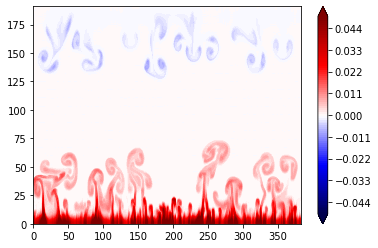

In [54]:
t=100
plt.figure()
cs=plt.contourf(np.transpose(T[t,:,:]),np.arange(-0.05,0.0501,0.001),cmap='seismic',extend='both')
plt.colorbar(cs)

In [ ]:
f = h5py.File('snapshots/snapshots.h5', 'r')
T = f['tasks']['T']
np.shape(T)
for t in range(0,np.shape(T)[0]):
    fig=plt.figure(figsize=(8.5, 3), dpi=300)
    cs=plt.contourf(xx*100,zz*100,T[t,:,:],np.arange(-0.05,0.05005,0.0005),cmap='seismic',extend='both')
    plt.colorbar(cs)
    fig.savefig('/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_'+str(t).zfill(4)+'.png', dpi=150, bbox_inches='tight')
    plt.close(fig) 

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/t_*.png"
fp_out = "/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=10, loop=0)


In [ ]:
!ls /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif

/content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/animation/image.gif


In [ ]:
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]
    print(np.shape(T))

(5000, 128, 64)


In [ ]:
np.array(T[0].T)

ValueError: ignored

In [ ]:
#Analysis 1 
#Convection plotting using temperature 
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    T = file['tasks']['T']
    t = T.dims[0]['sim_time']
    x = T.dims[1][0]
    z = T.dims[2][0]

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(7, 6), dpi=100)
    quad = plt.pcolormesh(x, z, T[0].T, shading='nearest', cmap='coolwarm',vmin=0,vmax=1e-1)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=T[:])
    animation.save('convection.gif',fps=200)



2022-03-21 02:59:21,625 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2022-03-21 02:59:21,629 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 700x600 -pix_fmt rgba -r 200 -i pipe: -vcodec h264 -pix_fmt yuv420p -y convection.gif
2022-03-21 02:59:21,825 matplotlib.animation 0/1 WARNING :: MovieWriter stderr:
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgs

CalledProcessError: ignored

ValueError: ignored

<Figure size 700x600 with 2 Axes>

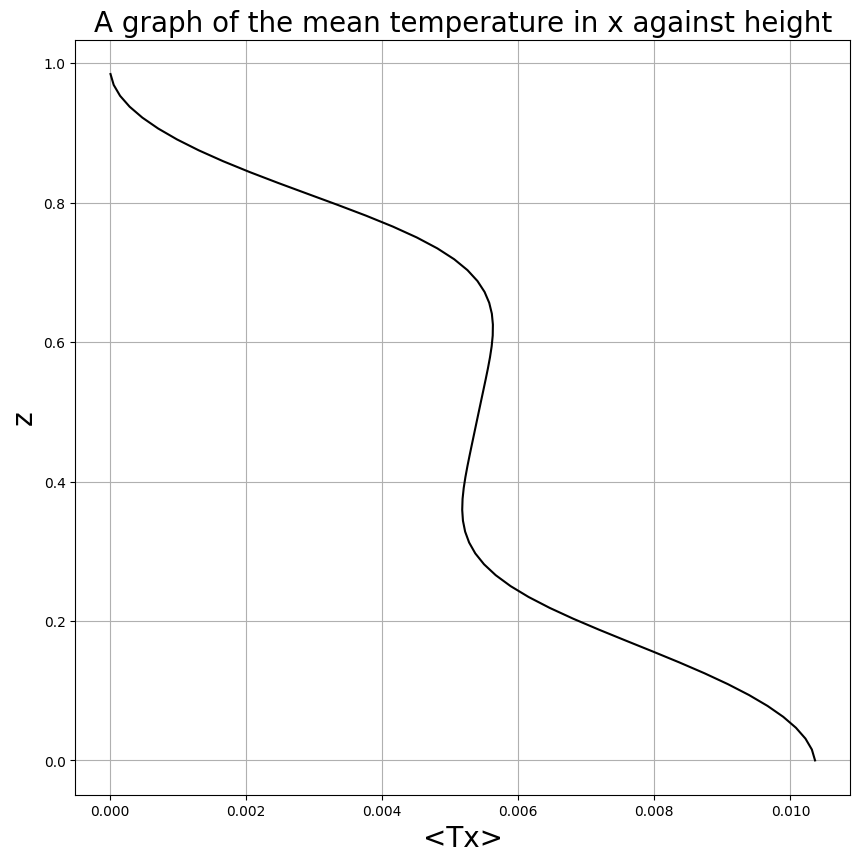

In [ ]:
#Analysis 2
#Plotting average temperature as a function of height
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    #Load analysis datasets:
    Tx = file['tasks']['<Tx>']
    z = np.arange(0.,d,1/zres)
    t = Tx.dims[0]

    #Plot data
    fig = plt.figure(figsize=(10,10), dpi=100)
    quad = plt.plot(Tx[-1][0][:],z,'black')
    plt.title('A graph of the mean temperature in x against height',fontsize=20)
    plt.grid()
    plt.xlabel('<Tx>',fontsize=20)
    plt.ylabel('z',fontsize=20)
    plt.savefig("meantemp.jpeg")

In [ ]:
#Analysis 3
#Convection plotting using kinetic energy
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    KE = file['tasks']['KE']
    t = KE.dims[0]['sim_time']
    x =KE.dims[1][0]
    z = KE.dims[2][0]

    KEmax = np.max(KE[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, KE[0].T, shading='nearest', cmap='inferno',vmin = 0,vmax=0. 95 * KEmax)
    plt.colorbar(label='Kinetic Energy')
    plt.title('A graph showing the kinetic energy of \na fluid in Rayleigh-Bernard convection through time')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=KE[:])
    animation.save('KEconvection.gif',fps=200)

In [ ]:
#Analysis 4
#Convection plotting using momentum
with h5py.File("snapshots/snapshots.h5", mode='r') as file:

    # Load datasets
    uvec = file['tasks']['|uvec|']
    t = uvec.dims[0]['sim_time']
    x =uvec.dims[1][0]
    z = uvec.dims[2][0]

    uvecmax = np.max(uvec[:][:][:])

    def animate(frame):
        quad.set_array(frame.T)

    #Plot data
    fig = plt.figure(figsize=(10, 10), dpi=100)
    quad = plt.pcolormesh(x, z, uvec[0].T, shading='nearest', cmap='inferno', vmin = 0, vmax= 0.95 * uvecmax)
    plt.colorbar(label='|u|')
    plt.title(' ')
    plt.xlabel('x', fontsize=20)
    plt.ylabel('z', fontsize=20)
    plt.tight_layout()

    #Animation
    animation = ani.FuncAnimation(fig, animate, frames=uvec[:])
    animation.save('uvec_convection.gif',fps=200)